# Benchmarking

This notebook benchmarks 5 algorithms on a ASC dataset for constrained neural networks training and is divided as follows: 

##### Deterministic Constraints:
1. Unconstrained Optimization Adam
2. [SSL-ALM](https://arxiv.org/abs/2504.07607) (Adam + SGD)
3. [Switching Subgradient](https://arxiv.org/abs/2301.13314) 
4. [Cooper](https://github.com/cooper-org/cooper?tab=readme-ov-file) (ALM version)
5. [CHOP](https://github.com/openopt/chop)

##### Stochastic Constraints:
1. Unconstrained Optimization Adam
2. [SSL-ALM](https://arxiv.org/abs/2504.07607) (Adam + SGD)
3. [Switching Subgradient](https://arxiv.org/abs/2301.13314) 
4. [Cooper](https://github.com/cooper-org/cooper?tab=readme-ov-file) (ALM version)

##### Importance Sampling:

split train and test

todo: for SSL-ALM compute balanced sampling constraints on train and in each iteration compute the whole test dataset

for SSL-ALM compute non-balanced sampling constraints on train and in each iteration compute the whole test dataset

compare the two

<br>

-------------------------------------------------------------------------------



In [5]:
# define the torch seed here
seed_n = 1
n_epochs = 50

# log path file
log_path = "./data/logs/log_benchmark.npz"

# Deterministic constraints: 
 
We aim to minimize the expected loss of $f$, where the implicit regression model is a neural network with its weights in a unit sphere. We problem can be defined as

\begin{aligned}
\min_{x \in \mathbb{R}^n} \quad & \mathbb{E}[f(x,\xi)] \\
\text{s.t.} \quad & \|W_i\|_F \le 1, \quad \forall i \in \{1,\ldots,L\},
\end{aligned}

where the $W_i$ is a weight matrix of the fully connected neural network, $||\cdot||_F$ is a Frobenius norm.

#### 1. Unconstrained Optimization

For setting a reference bar

In [9]:
# load and prepare data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import numpy as np
from folktables import ACSDataSource, ACSIncome, generate_categories

# load folktables data
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["VA"], download=True)
definition_df = data_source.get_definitions(download=True)
categories = generate_categories(features=ACSIncome.features, definition_df=definition_df)
df_feat, df_labels, _ = ACSIncome.df_to_pandas(acs_data,categories=categories, dummies=True)

In [10]:
sens_cols = ['SEX_Female', 'SEX_Male']
features = df_feat.drop(columns=sens_cols).to_numpy(dtype="float")
groups = df_feat[sens_cols].to_numpy(dtype="float")
labels = df_labels.to_numpy(dtype="float")

print(sens_cols)
print(features.shape)
print(groups.shape)
print(labels.shape)

['SEX_Female', 'SEX_Male']
(46144, 800)
(46144, 2)
(46144, 1)


In [11]:
# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# split
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    features, labels, groups, test_size=0.2, random_state=42)

# scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# make into a pytorch dataset, remove the sensitive attribute
features_train = torch.tensor(X_train, dtype=torch.float32)
labels_train = torch.tensor(y_train,dtype=torch.float32)
sens_train = torch.tensor(groups_train)
dataset_train = torch.utils.data.TensorDataset(features_train, labels_train)

In [5]:
import torch
from torch.nn import Sequential

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# create the dataloader
dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True)

# create small FC network
latent_size1 = 64
latent_size2 = 32
model = Sequential(
    torch.nn.Linear(features_train.shape[1], latent_size1),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size1, latent_size2),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size2, 1)
)

# get number of layers + number of biases
m = len(list(model.parameters()))

# create the SSLALM optimizer
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=0.001,
)

# bounds for the constraints: norm of each weight matrix should be <= 1
constraint_bounds = [1.]*m

# define epochs + loss function
criterion = torch.nn.BCEWithLogitsLoss()

In [6]:
# alloc arrays for plotting
Adam_loss_log_plotting = []
Adam_c_log_plotting    = []
Adam_std_loss_log_plotting = []
Adam_std_c_log_plotting = []

# training loop
for epoch in range(n_epochs):
    
    # alloc the logging arrays
    loss_log = []
    c_log = []

    # go through all data
    for batch_input, batch_label in dataloader:
        
        # calculate constraints - just for logging since this is an unconstrainted optimization
        c_log.append([])
        for i, param in enumerate(model.parameters()):

            # norm of the w. matrix
            norm = torch.linalg.norm(param, ord=2)

            # convert constraint to equality
            norm_viol = torch.max(
                norm 
                - constraint_bounds[i],
                torch.zeros(1)
            )   

            # save the value of the constraint
            c_log[-1].append(norm.detach().numpy())

        # calculate loss and grad
        batch_output = model(batch_input)
        loss = criterion(batch_output, batch_label)
        loss.backward()

        # save the loss and the dual variables
        loss_log.append(loss.detach().numpy())
        
        # update the primal variables together with smoothing dual variable
        optimizer.step()
        optimizer.zero_grad()
    
    # save the epoch values for plotting
    Adam_loss_log_plotting.append(np.mean(loss_log))
    Adam_c_log_plotting.append(np.mean(c_log, axis=0))
    Adam_std_loss_log_plotting.append(np.std(loss_log))
    Adam_std_c_log_plotting.append(np.std(c_log, axis=0))

    # print out the epoch values
    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
    )

Epoch: 0, loss: 0.45870882272720337, constraints: [4.892406   0.31928727 1.5516857  0.4506065  0.71107453 0.13503225], 
Epoch: 1, loss: 0.39446115493774414, constraints: [5.518849   0.3471279  1.6876335  0.46916848 0.7312506  0.13287035], 
Epoch: 2, loss: 0.38164374232292175, constraints: [5.6150737  0.34900537 1.7455273  0.47634044 0.749155   0.12971953], 
Epoch: 3, loss: 0.37222227454185486, constraints: [5.523676   0.35618073 1.8139473  0.4795078  0.7742632  0.12869503], 
Epoch: 4, loss: 0.36324581503868103, constraints: [5.449283   0.39863068 1.9029832  0.4857641  0.82546806 0.12741107], 
Epoch: 5, loss: 0.3523440361022949, constraints: [5.367149   0.46442527 2.02457    0.5056905  0.90122485 0.12718181], 
Epoch: 6, loss: 0.34078747034072876, constraints: [5.3218727 0.5499805 2.1359143 0.5236355 0.9999457 0.1262185], 
Epoch: 7, loss: 0.3291148543357849, constraints: [5.2538085  0.6464523  2.2500186  0.55353206 1.1046134  0.12528859], 
Epoch: 8, loss: 0.3169771730899811, constraints:

In [107]:
import numpy as np
import matplotlib.pyplot as plt

def plot_losses_and_constraints_multi(
    losses_list,
    constraints_list,
    constraint_thresholds,
    losses_std_list=None,
    titles=None,
    plot_individual_constraints=True,
    eval_points=2,
    std_multiplier=2,
):
    """
    Plot loss and constraint values for multiple ML algorithms with min-max, std, and eval points.

    Parameters
    ----------
    losses_list : list of np.ndarray or list of 2D np.ndarray
        Each element is either:
        - 1D array of losses for one algorithm, or
        - 2D array (num_runs x timesteps) for multiple runs.
    constraints_list : list of list of np.ndarray
        Each element is a list of 1D arrays (constraint values for that algorithm).
    constraint_thresholds : np.ndarray or list
        Threshold lines for constraints.
    losses_std_list : list of np.ndarray, optional
        1D array of std per algorithm.
    titles : list of str, optional
        Algorithm names.
    plot_individual_constraints : bool, default True
        Plot individual constraint curves.
    eval_points : int or array-like, default 2
        Epoch indices to mark with symbols.
    std_multiplier : float, default 2
        Multiplier for shading std bands.
    """
    # --- Color palette: Tableau 10 ---
    colors = [
        "#4E79A7", "#F28E2B", "#E15759", "#76B7B2", "#59A14F",
        "#EDC948", "#B07AA1", "#FF9DA7", "#9C755F", "#BAB0AB"
    ]
    # --- Marker styles ---
    marker_styles = ['o', 's', 'D', '^', 'v', '<', '>', 'P', 'X', '*']
    
    num_algos = len(losses_list)
    if titles is None:
        titles = [f"Algorithm {i+1}" for i in range(num_algos)]
    constraint_thresholds = np.atleast_1d(constraint_thresholds)

    fig, axes = plt.subplots(2, num_algos, figsize=(5*num_algos, 8), sharex='col')
    if num_algos == 1:
        axes = np.array([[axes[0]], [axes[1]]])  # consistent 2D indexing

    for j in range(num_algos):
        loss = np.asarray(losses_list[j])
        x = np.arange(loss.shape[-1])
        color = colors[j % len(colors)]

        # --- LOSS PLOT ---
        ax_loss = axes[0, j]
        # Multiple runs: min-max shading
        if loss.ndim == 2:
            loss_mean = np.mean(loss, axis=0)
            loss_min = np.min(loss, axis=0)
            loss_max = np.max(loss, axis=0)
            ax_loss.fill_between(x, loss_min, loss_max, color=color, alpha=0.15, label='Mean Loss +- Std')
        else:
            loss_mean = loss

        # Std shading
        if losses_std_list is not None and losses_std_list[j] is not None:
            loss_std = np.asarray(losses_std_list[j])
            ax_loss.fill_between(x, loss_mean - std_multiplier*loss_std,
                                 loss_mean + std_multiplier*loss_std,
                                 color=color, alpha=0.25, label=f'Loss ± Std')

        # Mean curve
        ax_loss.plot(x, loss_mean, color=color, lw=2, label=titles[j])

        # Eval points
        if eval_points is not None:
            if isinstance(eval_points, int):
                idx = np.arange(0, len(loss_mean), eval_points)
            else:
                idx = np.array(eval_points)
                idx = idx[idx < len(loss_mean)]
            ax_loss.plot(x[idx], loss_mean[idx], marker_styles[j], color=color, markersize=6)

        ax_loss.set_title(titles[j])
        ax_loss.set_ylabel("Mean Loss")
        ax_loss.grid(True, linestyle="--", alpha=0.35)
        ax_loss.legend(fontsize=9)

        # --- CONSTRAINT PLOT ---
        ax_constr = axes[1, j]
        constraints = np.array(constraints_list[j])
        x = np.arange(constraints.shape[1])
        color = colors[j % len(colors)]

        # Optional: individual constraint curves
        if plot_individual_constraints:
            for c in constraints:
                ax_constr.plot(x, c, color=color, alpha=0.6, lw=1.5)

        # Min-Max band for constraints
        c_min = np.min(constraints, axis=0)
        c_max = np.max(constraints, axis=0)
        ax_constr.fill_between(x, c_min, c_max, color=color, alpha=0.15, label='Constraint Range')

        # Threshold lines
        for th in constraint_thresholds:
            ax_constr.axhline(th, color="red", linestyle="--", lw=1.4, label="Threshold")

        ax_constr.set_ylabel("Constraint")
        ax_constr.grid(True, linestyle="--", alpha=0.35)
        ax_constr.legend(fontsize=9)

    axes[-1, 0].set_xlabel("Epoch")
    plt.tight_layout()
    plt.show()


In [8]:
# save the computed data
np.savez(log_path, losses=[np.array(Adam_loss_log_plotting)], constraints=[np.array(Adam_c_log_plotting).T], 
                    losses_std=[np.array(Adam_std_loss_log_plotting)])

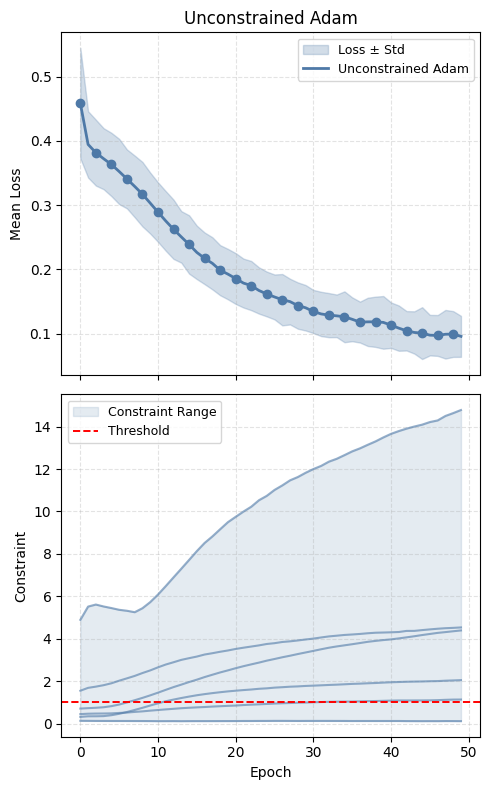

In [9]:
# plot the current results
losses = np.load(log_path)["losses"]
constraints = np.load(log_path)["constraints"]
losses_std = np.load(log_path)["losses_std"]
thresholds = [ constraint_bounds[0] ]

plot_losses_and_constraints_multi(losses, constraints, thresholds, losses_std_list=losses_std, 
                            titles=['Unconstrained Adam'], plot_individual_constraints=True, std_multiplier=1)

#### 2.1 SSL-ALM SGD

In [10]:
from humancompatible.train.algorithms import SSLALM

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# create the dataloader
dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True)

# create small FC network
latent_size1 = 64
latent_size2 = 32
model = Sequential(
    torch.nn.Linear(features_train.shape[1], latent_size1),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size1, latent_size2),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size2, 1)
)

# get number of layers + number of biases
m = len(list(model.parameters()))

# create the SSLALM optimizer
optimizer = SSLALM(
    params=model.parameters(),
    m=m,
    lr=0.01,
    dual_lr=0.1
)

# bounds for the constraints: norm of each weight matrix should be <= 1
constraint_bounds = [1.]*m

# define epochs + loss function
criterion = torch.nn.BCEWithLogitsLoss()

In [11]:
# alloc arrays for plotting
SSL_ALM_loss_log_plotting = []
SSL_ALM_c_log_plotting    = []
SSL_ALM_std_loss_log_plotting = []

# training loop
for epoch in range(n_epochs):
    
    # alloc the logging arrays
    loss_log = []
    c_log = []
    duals_log = []

    # go through all data
    for batch_input, batch_label in dataloader:
        
        # calculate constraints and constraint grads - constraint per each weight matrix
        c_log.append([])
        for i, param in enumerate(model.parameters()):

            # norm of the w. matrix
            norm = torch.linalg.norm(param, ord=2)

            # convert constraint to equality
            norm_viol = torch.max(
                norm 
                - constraint_bounds[i],
                torch.zeros(1)
            )   

            # calculate the Jacobian of the constraint
            norm_viol.backward()

            # update the dual variable + save the Jacobian for later - its needed in the primal variable update
            optimizer.dual_step(i, c_val=norm_viol)
            optimizer.zero_grad()

            # save the value of the constraint
            c_log[-1].append(norm.detach().numpy())
        
        # calculate loss and grad
        batch_output = model(batch_input)
        loss = criterion(batch_output, batch_label)
        loss.backward()

        # save the loss and the dual variables
        loss_log.append(loss.detach().numpy())
        duals_log.append(optimizer._dual_vars.detach())
        
        # update the primal variables together with smoothing dual variable
        optimizer.step()
        optimizer.zero_grad()
    
    # save the epoch values for plotting
    SSL_ALM_loss_log_plotting.append(np.mean(loss_log))
    SSL_ALM_c_log_plotting.append(np.mean(c_log, axis=0))
    SSL_ALM_std_loss_log_plotting.append(np.std(loss_log))

    # print out the epoch values
    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
        f"dual: {np.mean(duals_log, axis=0)}"
    )

Epoch: 0, loss: 0.5579718947410583, constraints: [0.91289365 0.24924642 0.98641264 0.46461216 0.8706531  0.0809375 ], dual: [0.15808122 0.         0.15734595 0.         0.18665232 0.        ]
Epoch: 1, loss: 0.4504135251045227, constraints: [0.99983734 0.6695479  0.9999918  0.620562   0.99979573 0.1346861 ], dual: [0.20943607 0.         0.24302068 0.         0.26294106 0.        ]
Epoch: 2, loss: 0.4304836094379425, constraints: [0.9995162  0.9619825  0.999482   0.68241566 0.9993693  0.12400071], dual: [0.24706516 0.02461725 0.29858512 0.         0.31679347 0.        ]
Epoch: 3, loss: 0.4220561981201172, constraints: [0.99928004 0.9998961  0.9991873  0.714672   0.9990925  0.11561225], dual: [0.2747239  0.03297184 0.34435636 0.         0.36106533 0.        ]
Epoch: 4, loss: 0.4155169725418091, constraints: [0.9992754  0.9998498  0.9989219  0.73707056 0.9988016  0.11102299], dual: [0.29876593 0.03830024 0.38133433 0.         0.39619225 0.        ]
Epoch: 5, loss: 0.41038405895233154, con

In [12]:
# load the prior and append
losses = list(np.load(log_path)["losses"])
constraints = list(np.load(log_path)["constraints"])
losses_std = list(np.load(log_path)["losses_std"])

# append
losses += [np.array(SSL_ALM_loss_log_plotting)]
constraints += [np.array(SSL_ALM_c_log_plotting).T]
losses_std += [np.array(SSL_ALM_std_loss_log_plotting)]

# save the computed data
np.savez(log_path, losses=losses, constraints=constraints, losses_std=losses_std)

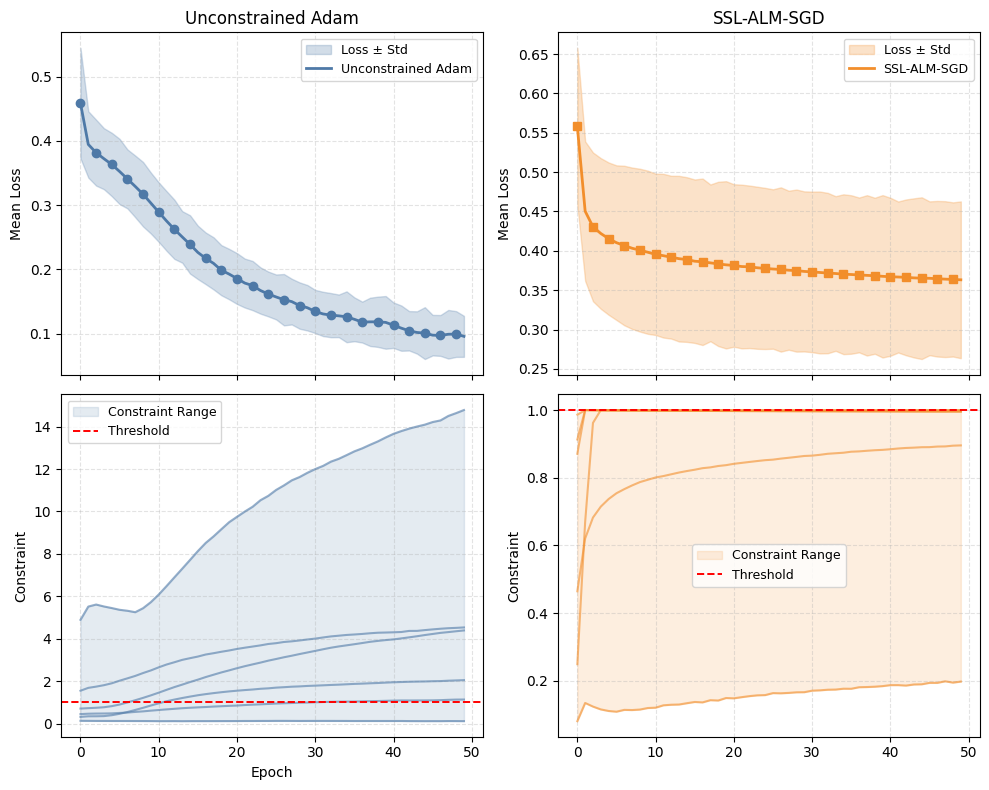

In [13]:
# plot the current results
losses = np.load(log_path)["losses"]
constraints = np.load(log_path)["constraints"]
losses_std = np.load(log_path)["losses_std"]
thresholds = [ constraint_bounds[0] ]

plot_losses_and_constraints_multi(losses, constraints, thresholds, losses_std_list=losses_std,  std_multiplier=1,
                                  titles=['Unconstrained Adam', 'SSL-ALM-SGD'], plot_individual_constraints=True)

#### 2.2 SSL-ALM Adam

In [14]:
import sys, os
# Add the ../src folder to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.humancompatible.train.optim.ssl_alm_adam import SSLALM_Adam

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# create the dataloader
dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True)

# create small FC network
latent_size1 = 64
latent_size2 = 32
model = Sequential(
    torch.nn.Linear(features_train.shape[1], latent_size1),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size1, latent_size2),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size2, 1)
)

# get number of layers + number of biases
m = len(list(model.parameters()))

# create the SSLALM optimizer
optimizer = SSLALM_Adam(
    params=model.parameters(),
    m=m,
    lr=0.001,
    dual_lr=0.1
)

# bounds for the constraints: norm of each weight matrix should be <= 1
constraint_bounds = [1.]*m

# define epochs + loss function
criterion = torch.nn.BCEWithLogitsLoss()

In [15]:
# alloc arrays for plotting
SSL_ALM_Adam_loss_log_plotting = []
SSL_ALM_Adam_c_log_plotting    = []
SSL_ALM_Adam_std_c_log_plotting    = []

# training loop
for epoch in range(n_epochs):
    
    # alloc the logging arrays
    loss_log = []
    c_log = []
    duals_log = []

    # go through all data
    for batch_input, batch_label in dataloader:
        
        # calculate constraints and constraint grads - constraint per each weight matrix
        c_log.append([])
        for i, param in enumerate(model.parameters()):

            # norm of the w. matrix
            norm = torch.linalg.norm(param, ord=2)

            # convert constraint to equality
            norm_viol = torch.max(
                norm 
                - constraint_bounds[i],
                torch.zeros(1)
            )   

            # calculate the Jacobian of the constraint
            norm_viol.backward()

            # update the dual variable + save the Jacobian for later - its needed in the primal variable update
            optimizer.dual_step(i, c_val=norm_viol[0])
            optimizer.zero_grad()

            # save the value of the constraint
            c_log[-1].append(norm.detach().numpy())
        
        # calculate loss and grad
        batch_output = model(batch_input)
        loss = criterion(batch_output, batch_label)
        loss.backward()

        # save the loss and the dual variables
        loss_log.append(loss.detach().numpy())
        duals_log.append(optimizer._dual_vars.detach())
        
        # update the primal variables together with smoothing dual variable
        optimizer.step()
        optimizer.zero_grad()
    
    # save the epoch values for plotting
    SSL_ALM_Adam_loss_log_plotting.append(np.mean(loss_log))
    SSL_ALM_Adam_c_log_plotting.append(np.mean(c_log, axis=0))          
    SSL_ALM_Adam_std_c_log_plotting.append(np.std(loss_log))                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

    # print out the epoch values
    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
        f"dual: {np.mean(duals_log, axis=0)}"
    )

Epoch: 0, loss: 0.47237837314605713, constraints: [0.9925282  0.8578605  0.9960306  0.5817014  0.97313595 0.11154877], dual: [0.22479261 0.03087937 0.26491326 0.         0.18057247 0.        ]
Epoch: 1, loss: 0.4328916370868683, constraints: [0.99981815 0.99883825 0.9945939  0.6752885  0.99872744 0.10275991], dual: [0.29251978 0.03858675 0.32678738 0.         0.20986943 0.        ]
Epoch: 2, loss: 0.42501601576805115, constraints: [0.99958366 0.99906313 0.9945085  0.73531103 0.99886656 0.09978881], dual: [0.35241222 0.04249056 0.3697336  0.         0.23132321 0.        ]
Epoch: 3, loss: 0.4201308786869049, constraints: [0.99940085 0.9990588  0.99555016 0.7894717  0.9989862  0.09556165], dual: [0.40895203 0.04553234 0.40539867 0.         0.2516227  0.        ]
Epoch: 4, loss: 0.41494959592819214, constraints: [0.9991474  0.9991321  0.99546045 0.8449935  0.9989612  0.09300704], dual: [0.4610153  0.04825373 0.43609595 0.         0.26891962 0.        ]
Epoch: 5, loss: 0.41152268648147583, 

In [16]:
# load the prior and append
losses = list(np.load(log_path)["losses"])
constraints = list(np.load(log_path)["constraints"])
losses_std = list(np.load(log_path)["losses_std"])

# append
losses += [np.array(SSL_ALM_Adam_loss_log_plotting)]
constraints += [np.array(SSL_ALM_Adam_c_log_plotting).T]
losses_std += [np.array(SSL_ALM_Adam_std_c_log_plotting)]

# save the computed data
np.savez(log_path, losses=losses, constraints=constraints, losses_std=losses_std)

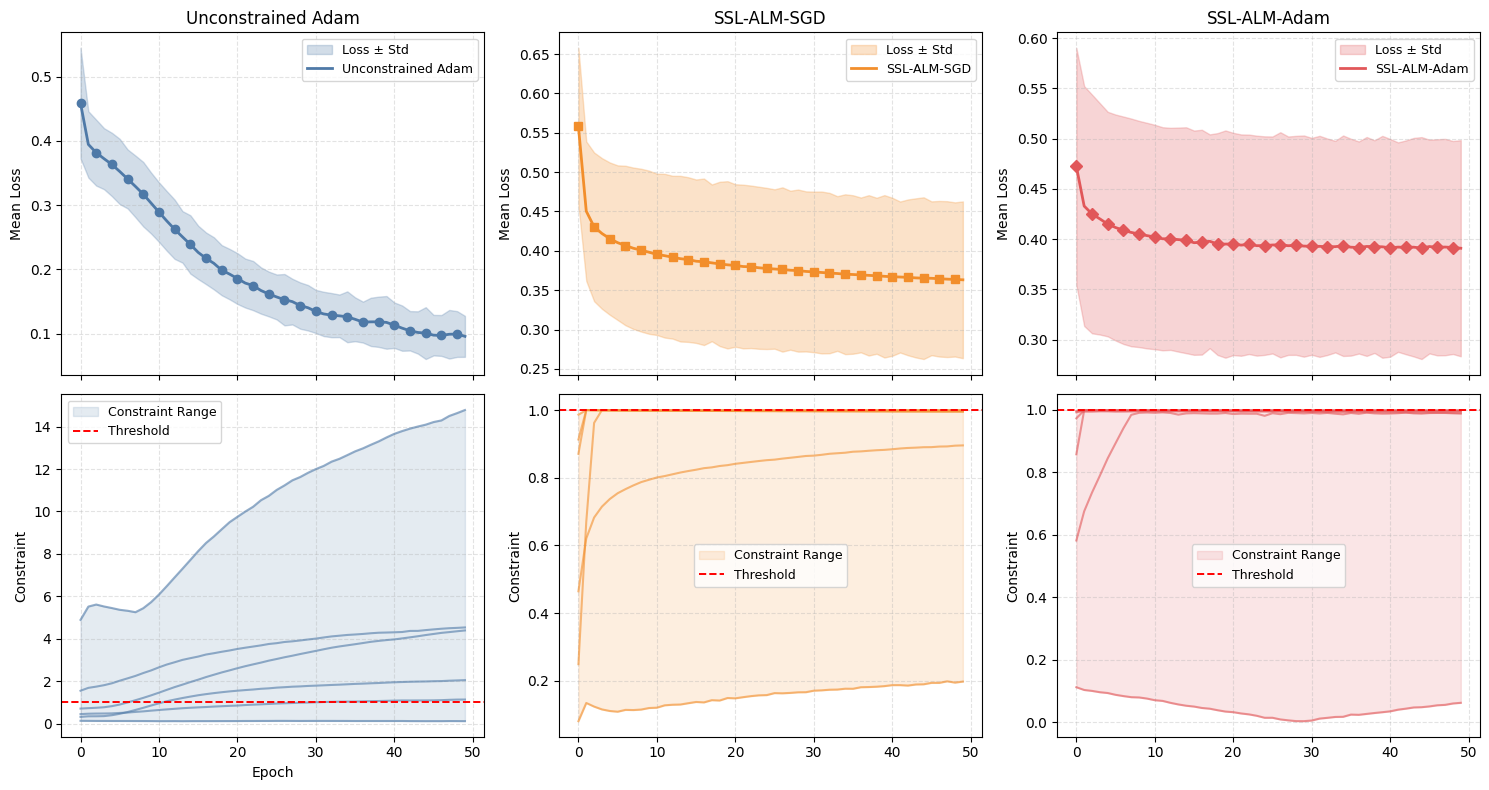

In [17]:
# plot the current results
losses = np.load(log_path)["losses"]
constraints = np.load(log_path)["constraints"]
losses_std = np.load(log_path)["losses_std"]
thresholds = [ constraint_bounds[0] ]

plot_losses_and_constraints_multi(losses, constraints, thresholds, losses_std_list=losses_std,  std_multiplier=1,
                                  titles=['Unconstrained Adam', 'SSL-ALM-SGD', 'SSL-ALM-Adam'], plot_individual_constraints=True)

#### 3. Switching-Subgradient

In [18]:
from humancompatible.train.algorithms import SSG

# set the seed for fair comparisons
torch.manual_seed(seed_n)

# create the dataloader
dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True)

# create small FC network - same as the other algorithms
latent_size1 = 64
latent_size2 = 32
model = Sequential(
    torch.nn.Linear(features_train.shape[1], latent_size1),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size1, latent_size2),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size2, 1)
)

# get number of layers + number of biases
m = len(list(model.parameters()))

# create the SSLALM optimizer
optimizer = SSG(
    params=model.parameters(),
    m=1,
    lr=0.01,
    dual_lr=0.1
)

# bounds for the constraints: norm of max each weight matrix should be <= 1
constraint_bounds = [1.]

# define epochs + loss function - same loss should be defined for all algorithms
criterion = torch.nn.BCEWithLogitsLoss()

In [19]:
# alloc the plotting array
SSG_c_log_plotting = []
SSG_loss_log_plotting = []
SSG_std_loss_log_plotting = []

# training loop
for epoch in range(n_epochs):
    
    # alloc logging array
    loss_log = []
    c_log = []
    duals_log = []

    # train for all data
    for batch_input, batch_label in dataloader:
        
        # prepare the max of the violation
        max_norm_viol = torch.zeros(1)
        c_log.append([])
        
        # calculate constraints and constraint grads - max of constraint per each weight matrix
        for i, param in enumerate(model.parameters()):

            # norm of the w. matrix
            norm = torch.linalg.norm(param, ord=2)

            # convert constraint to equality
            norm_viol = torch.max(
                norm 
                - constraint_bounds[0],
                torch.zeros(1)
            )   

            # save the max 
            max_norm_viol = torch.max(max_norm_viol, norm_viol)

            # save the value of the constraint
            c_log[-1].append(norm.detach().numpy())

        # calculate the Jacobian of the max-violating norm constraint
        max_norm_viol.backward()

        # save the gradient of the constraint
        optimizer.dual_step(0)
        optimizer.zero_grad()

        # calculate loss and grad
        out = model(batch_input)
        loss = criterion(out, batch_label)
        loss.backward()
        
        # save the loss value
        loss_log.append(loss.detach().numpy())
        
        # perform a step - either update based on the loss grad or constraint grad
        optimizer.step(max_norm_viol)
        optimizer.zero_grad()
        
    # save the epoch values for plotting
    SSG_loss_log_plotting.append(np.mean(loss_log))
    SSG_c_log_plotting.append(np.mean(c_log, axis=0))
    SSG_std_loss_log_plotting.append(np.std(loss_log))
    
    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
    )

Epoch: 0, loss: 0.5636869072914124, constraints: [0.8865569  0.2551967  0.9572769  0.46421272 0.8471299  0.07630552], 
Epoch: 1, loss: 0.4628611207008362, constraints: [0.9514828  0.6902075  0.967227   0.61517787 0.95142245 0.12884726], 
Epoch: 2, loss: 0.4419809579849243, constraints: [0.95245636 0.9431201  0.9661805  0.67615    0.9523784  0.12224942], 
Epoch: 3, loss: 0.43266552686691284, constraints: [0.96838695 0.9559374  0.9640981  0.71008044 0.95307636 0.11462068], 
Epoch: 4, loss: 0.42572417855262756, constraints: [0.96794224 0.9495907  0.9647045  0.73499    0.9521954  0.10768438], 
Epoch: 5, loss: 0.4200306534767151, constraints: [0.9737459  0.9542855  0.96672106 0.75389665 0.9529736  0.10590638], 
Epoch: 6, loss: 0.41630467772483826, constraints: [0.9797309  0.9470746  0.96606255 0.7677217  0.95301396 0.10679292], 
Epoch: 7, loss: 0.41277119517326355, constraints: [0.97991216 0.9549681  0.9622258  0.78073645 0.95376104 0.10501108], 
Epoch: 8, loss: 0.41035348176956177, constra

In [20]:
# load the prior and append
losses = list(np.load(log_path)["losses"])
constraints = list(np.load(log_path)["constraints"])
losses_std = list(np.load(log_path)["losses_std"])

# append
losses += [np.array(SSG_loss_log_plotting)]
constraints += [np.array(SSG_c_log_plotting).T]
losses_std += [np.array(SSG_std_loss_log_plotting)]

# save the computed data
np.savez(log_path, losses=losses, constraints=constraints, losses_std=losses_std)

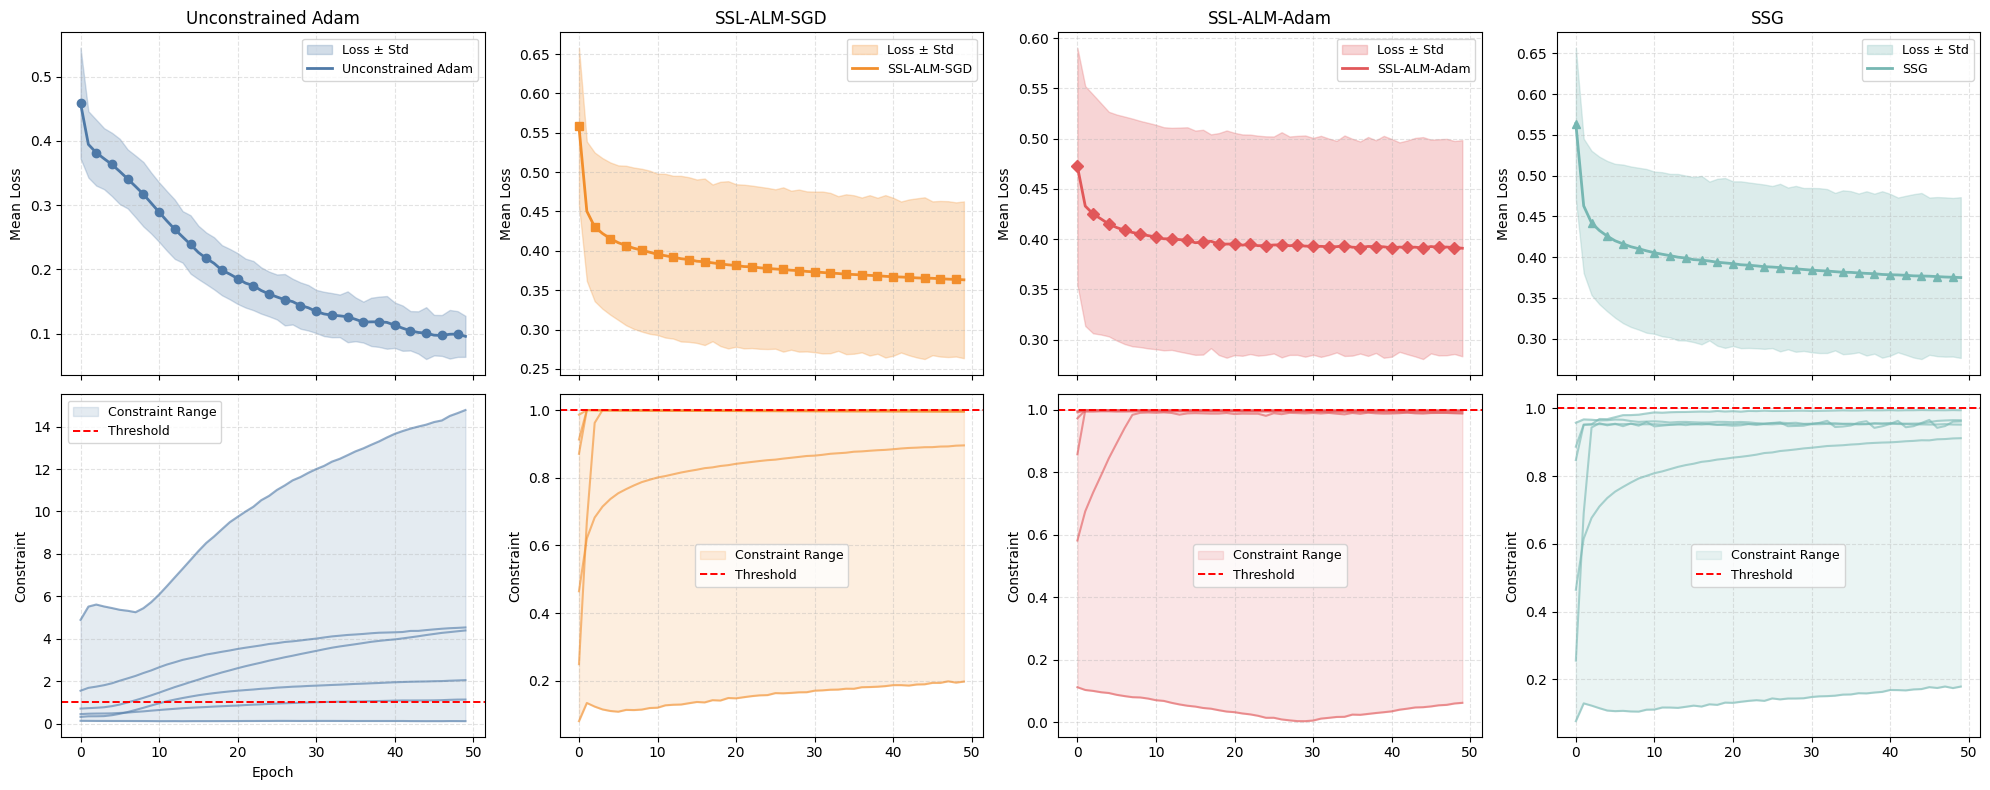

In [21]:
# plot the current results
losses = np.load(log_path)["losses"]
constraints = np.load(log_path)["constraints"]
losses_std = np.load(log_path)["losses_std"]
thresholds = [ constraint_bounds[0] ]

plot_losses_and_constraints_multi(losses, constraints, thresholds, losses_std_list=losses_std,  std_multiplier=1,
                                  titles=['Unconstrained Adam', 'SSL-ALM-SGD', 'SSL-ALM-Adam', 'SSG'], plot_individual_constraints=True)

#### 4. Cooper - Augmented Lagrangian

In [22]:
# set the seed for fair comparisons
torch.manual_seed(seed_n)

# create the dataloader
dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True)

# create small FC network - same as the other algorithms
latent_size1 = 64
latent_size2 = 32
model = Sequential(
    torch.nn.Linear(features_train.shape[1], latent_size1),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size1, latent_size2),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size2, 1)
)

# get number of layers + number of biases
m = len(list(model.parameters()))

# bounds for the constraints: norm of max each weight matrix should be <= 1
constraint_bounds = [1.]*m

# define epochs + loss function - same loss should be defined for all algorithms
criterion = torch.nn.BCEWithLogitsLoss()

In [23]:
import cooper

# select device
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = "cpu"

# define the problem
class ACS_Deterministic_Constr_Fair_ALM(cooper.ConstrainedMinimizationProblem):
    def __init__(self, formulation_type):
        super().__init__()


        # define the number of multipliers - same as the number of constraints
        if not formulation_type.expects_multiplier:
            self.multiplier = None
        else:
            self.multiplier = cooper.multipliers.DenseMultiplier(num_constraints=len(list(model.parameters())), device=DEVICE) 

        # add the penalty coefficient - augmented lagrangian
        if not formulation_type.expects_penalty_coefficient:
            self.penalty = None
        else:
            self.penalty = cooper.penalty_coefficients.DensePenaltyCoefficient(
                init=torch.tensor(1.0, device=DEVICE),
            )
        
        # inequality constraints on the norm of the matrix
        self.constraint = cooper.Constraint(
            constraint_type=cooper.ConstraintType.INEQUALITY,
            formulation_type=formulation_type,
            multiplier=self.multiplier,
            penalty_coefficient=self.penalty,
        )


    # function that computes the constraints and the loss function
    def compute_cmp_state(self, model, inputs, targets):

        # compute the yhat loss
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        loss = criterion( model(inputs) , targets )

        # calculate constraints
        norm_values_c = []
        for i, param in enumerate(model.parameters()):

            # norm of the w. matrix
            norm = torch.linalg.norm(param, ord=2)

            # compute the violation of the constraint
            norm_viol = norm - constraint_bounds[i] 
            norm_values_c.append(norm_viol)
        
        # compute the constraint violation
        constraint_state = cooper.ConstraintState(violation=torch.stack(norm_values_c))
        observed_constraints = {self.constraint: constraint_state}

        return cooper.CMPState(loss=loss, observed_constraints=observed_constraints)


In [24]:
# create the problem
problem = ACS_Deterministic_Constr_Fair_ALM(cooper.formulations.AugmentedLagrangian)

# flag of dual variables
has_dual_variables = problem.multiplier is not None

# create the primal optimizer
primal_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# create the dual optimizer
if has_dual_variables:
    dual_optimizer = torch.optim.SGD(problem.dual_parameters(), lr=0.1, maximize=True)

    # combine the optimizers
    constrained_optimizer = cooper.optim.SimultaneousOptimizer(
        cmp=problem,
        primal_optimizers=primal_optimizer,
        dual_optimizers=dual_optimizer,
    )
else:
    # Formulations without dual variables, such as the Quadratic Penalty
    # formulation, do not require a dual optimizer
    constrained_optimizer = cooper.optim.UnconstrainedOptimizer(
        cmp=problem,
        primal_optimizers=primal_optimizer,
    )

# Increase the penalty coefficient by `increment` if the constraint is violate by more
# than `violation_tolerance`- keep this the same - since its not included in SSL-ALM implementation
penalty_scheduler = cooper.penalty_coefficients.AdditivePenaltyCoefficientUpdater(
    increment=0.0, 
    violation_tolerance=1e-3,
)

In [25]:
# alloc arrays for plotting
Cooper_c_log_plotting    = []
Cooper_loss_log_plotting = []
Cooper_std_loss_log_plotting = []

# training loop
for epoch in range(n_epochs):

    # alloc the logging arrays
    loss_log = []
    c_log = []
    duals_log = []
    penalty_coefficient_values = []

    # alloc norm values array
    norm_values_c = []

    # go through all data
    for batch_input, batch_label in dataloader:

        # calculate constraints - just for logging
        c_log.append([])
        for i, param in enumerate(model.parameters()):

            # norm of the w. matrix
            norm = torch.linalg.norm(param, ord=2)

            # save the value of the constraint
            c_log[-1].append(norm.detach().numpy())

        # compute the loss - just for logging purposes
        loss = criterion( model(batch_input) , batch_label )
        loss_log.append(loss.item())

        # compute the states
        compute_cmp_state_kwargs = {"model": model, "inputs": batch_input, "targets": batch_label}
        roll_out = constrained_optimizer.roll(compute_cmp_state_kwargs=compute_cmp_state_kwargs)

        # Update the penalty coefficient
        constraint_state = roll_out.cmp_state.observed_constraints[problem.constraint]
        penalty_scheduler.update_penalty_coefficient_(problem.constraint, constraint_state)

        # get the dual variables and the coefficients
        multiplier_value = problem.multiplier.weight.detach().numpy() if has_dual_variables else None
        penalty_coefficient_value = problem.constraint.penalty_coefficient().item()

        # save the duals and penalty coefficients
        duals_log.append(multiplier_value)
        penalty_coefficient_values.append(penalty_coefficient_value)

    # save the epoch values for plotting
    Cooper_loss_log_plotting.append(np.mean(loss_log))
    Cooper_c_log_plotting.append(np.mean(c_log, axis=0))
    Cooper_std_loss_log_plotting.append(np.std(loss_log))

    # print out the epoch values
    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
        f"dual: {np.mean(duals_log, axis=0)}, "
        f"penalty coefficients: {np.mean(penalty_coefficient_values, axis=0)}, "
    )
    

Epoch: 0, loss: 0.46958190384135295, constraints: [0.99976677 0.8926508  0.99872273 0.56393003 0.9766951  0.11744822], dual: [ 0.12781249 -0.00728231  0.04969095 -0.04358035  0.03269594 -0.08821859], penalty coefficients: 1.0, 
Epoch: 1, loss: 0.44396884444345636, constraints: [1.0000159  0.9991876  0.9995607  0.7077899  0.99948525 0.10157069], dual: [ 0.14718805  0.00678802  0.05762342 -0.02920533  0.04860059 -0.08980437], penalty coefficients: 1.0, 
Epoch: 2, loss: 0.43609511279589797, constraints: [0.99984884 0.9989382  0.999755   0.850791   0.99942815 0.09110989], dual: [ 0.14650744  0.00697396  0.05950342 -0.01491133  0.0528332  -0.0908498 ], penalty coefficients: 1.0, 
Epoch: 3, loss: 0.43284569804651896, constraints: [1.0000898  0.99952126 1.0000215  0.9688286  0.9996671  0.08414535], dual: [ 0.14562361  0.00708504  0.06216376 -0.00299561  0.05468437 -0.09154589], penalty coefficients: 1.0, 
Epoch: 4, loss: 0.4285415715797832, constraints: [1.0001297  0.99960524 0.9999504  0.989

In [26]:
# load the prior and append
losses = list(np.load(log_path)["losses"])
constraints = list(np.load(log_path)["constraints"])
losses_std = list(np.load(log_path)["losses_std"])

# append
losses += [np.array(Cooper_loss_log_plotting)]
constraints += [np.array(Cooper_c_log_plotting).T]
losses_std += [np.array(Cooper_std_loss_log_plotting)]

# save the computed data
np.savez(log_path, losses=losses, constraints=constraints, losses_std=losses_std)

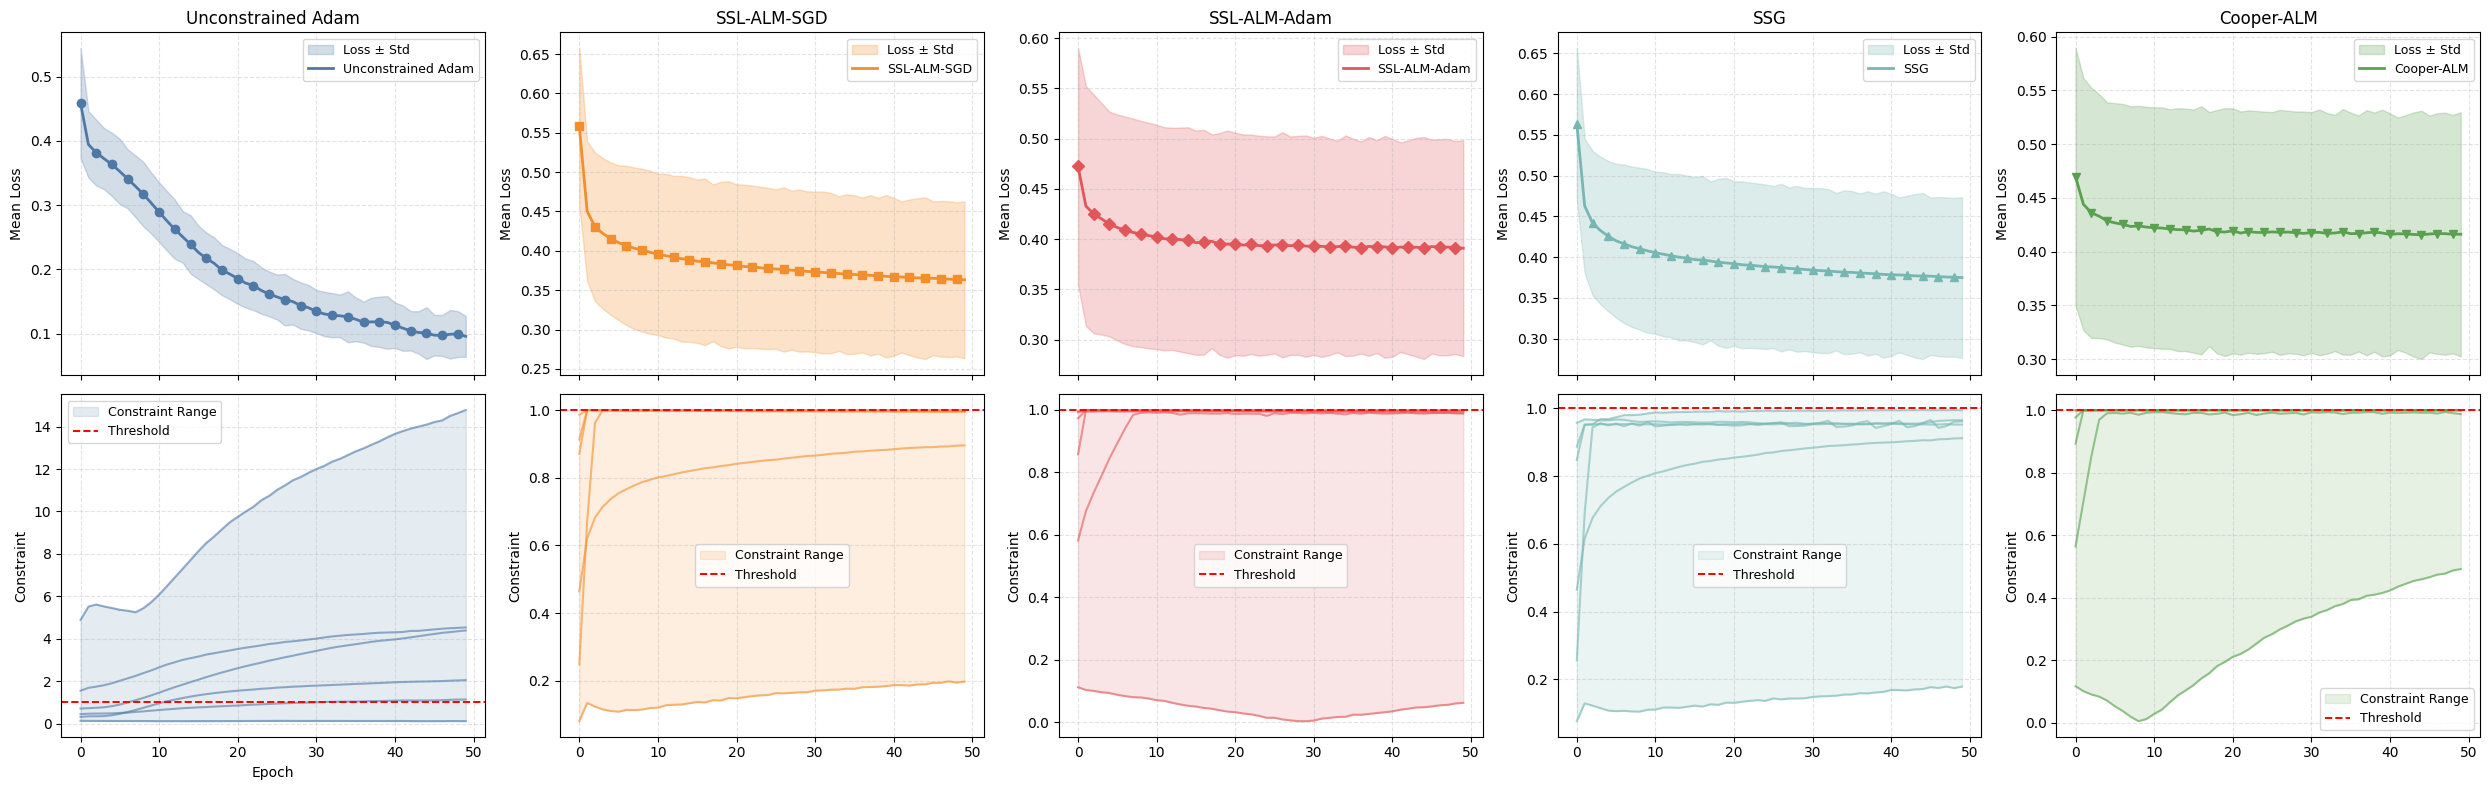

In [27]:
# plot the current results
losses = np.load(log_path)["losses"]
constraints = np.load(log_path)["constraints"]
losses_std = np.load(log_path)["losses_std"]
thresholds = [ constraint_bounds[0] ]

plot_losses_and_constraints_multi(losses, constraints, thresholds, losses_std_list=losses_std,  std_multiplier=1,
                                  titles=['Unconstrained Adam', 'SSL-ALM-SGD', 'SSL-ALM-Adam', 'SSG', 'Cooper-ALM'], plot_individual_constraints=True)

#### 5. CHOP

The library is based on the [Stochastic Franke-Wolfe (SFW)](https://arxiv.org/pdf/2010.07243), which constraints the parameters on a convex set. Thus, the model weights are to be in a closed ball, simplex and such. This can only be used for the determinitic case of benchmarking but cannot be extended to the stochastic constrained case. 

NOTE: The repo has an error in it. <code>chop/constraints.py</code>, line 292: 

<code>update_direction = iterate.clone().detach()</code> change to 

<code>update_direction = -iterate.clone().detach()</code>

In [28]:
import chop

# set the seed for fair comparisons
torch.manual_seed(seed_n)

# create the dataloader
dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True)

# create small FC network - same as the other algorithms
latent_size1 = 64
latent_size2 = 32
model = Sequential(
    torch.nn.Linear(features_train.shape[1], latent_size1),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size1, latent_size2),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size2, 1)
)

# get number of layers + number of biases
m = len(list(model.parameters()))

# bounds for the constraints: norm of max each weight matrix should be <= 1
constraint_bounds = [1.]

# define epochs + loss function - same loss should be defined for all algorithms
criterion = torch.nn.BCEWithLogitsLoss()

In [29]:
# create an optimizer with a ball constraints
optimizer = chop.stochastic.FrankWolfe(model.parameters(), chop.constraints.L2Ball(alpha=constraint_bounds[0]),
                                       lr=0.001, momentum=0.9,
                                       normalization='gradient')

bias_params = [param for name, param in model.named_parameters() if 'bias' in name]
bias_opt = chop.stochastic.PGD(bias_params, chop.constraints.L2Ball(alpha=constraint_bounds[0]), lr=0.001)

# project the model weights into the feasible region (an assumption of the franke-wolfe)
for i, param in enumerate(model.parameters()):
    param_proj = chop.constraints.L2Ball(alpha=constraint_bounds[0]).prox(param)

    # Update the parameter in-place
    with torch.no_grad():
        param.copy_(param_proj)

/home/bosadam/Documents/Doktorat/humancompatible-train/env_fairbench/lib/python3.11/site-packages/chop/utils/utils.py:96: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4416.)
  return torch.mul(tensor.T, other.T).T


In [30]:
# alloc arrays for plotting
CHOP_c_log_plotting    = []
CHOP_loss_log_plotting = []
CHOP_std_loss_log_plotting = []

model.train()   

# training loop
for epoch in range(n_epochs):

    # alloc the logging arrays
    loss_log = []
    c_log = []
    duals_log = []

    # alloc norm values array
    norm_values_c = []

    # go through all data
    for batch_input, batch_label in dataloader:

        # calculate constraints - just for logging
        c_log.append([])
        for i, param in enumerate(model.parameters()):

            # norm of the w. matrix
            norm = torch.linalg.norm(param, ord=2)

            # save the value of the constraint
            c_log[-1].append(norm.detach().numpy())

        # compute the loss - just for logging purposes
        optimizer.zero_grad()
        bias_opt.zero_grad()
        loss = criterion(model(batch_input), batch_label)
        loss.backward()
        optimizer.step()
        bias_opt.step()

        # save the loss for later
        loss_log.append(loss.item())

    # save the epoch values for plotting
    CHOP_loss_log_plotting.append(np.mean(loss_log))
    CHOP_c_log_plotting.append(np.mean(c_log, axis=0))
    CHOP_std_loss_log_plotting.append(np.std(loss_log))

    # print out the epoch values
    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
    )
    

Epoch: 0, loss: 0.6901379895220596, constraints: [0.71410966 0.15037718 0.9213575  0.38696805 0.5187366  0.05996813], 
Epoch: 1, loss: 0.6815355538650443, constraints: [0.6719315  0.14869304 0.89898914 0.3906492  0.4921078  0.1221429 ], 
Epoch: 2, loss: 0.6796294381290002, constraints: [0.6299808  0.14887948 0.87930346 0.38907287 0.48109508 0.1448769 ], 
Epoch: 3, loss: 0.6777218506644049, constraints: [0.58743733 0.15071158 0.8603447  0.386782   0.47844154 0.14673577], 
Epoch: 4, loss: 0.6753192744645543, constraints: [0.5429646  0.15495576 0.8416517  0.3857915  0.48474053 0.14734434], 
Epoch: 5, loss: 0.6719240562238148, constraints: [0.49571553 0.16358942 0.8225961  0.38524923 0.5029483  0.13464458], 
Epoch: 6, loss: 0.6671010472745581, constraints: [0.44832343 0.17927991 0.80298394 0.38860273 0.53512126 0.12838209], 
Epoch: 7, loss: 0.6598202929391398, constraints: [0.40977186 0.20765392 0.78299564 0.3940621  0.58376724 0.11594684], 
Epoch: 8, loss: 0.6485556775713711, constraints:

In [31]:
# load the prior and append
losses = list(np.load(log_path)["losses"])
constraints = list(np.load(log_path)["constraints"])
losses_std = list(np.load(log_path)["losses_std"])

# append
losses += [np.array(CHOP_loss_log_plotting)]
constraints += [np.array(CHOP_c_log_plotting).T]
losses_std += [np.array(CHOP_std_loss_log_plotting)]

# save the computed data
np.savez(log_path, losses=losses, constraints=constraints, losses_std=losses_std)

#### Results

We first plot all algorithms separately. This makes it easy to see the violation of each constraint.

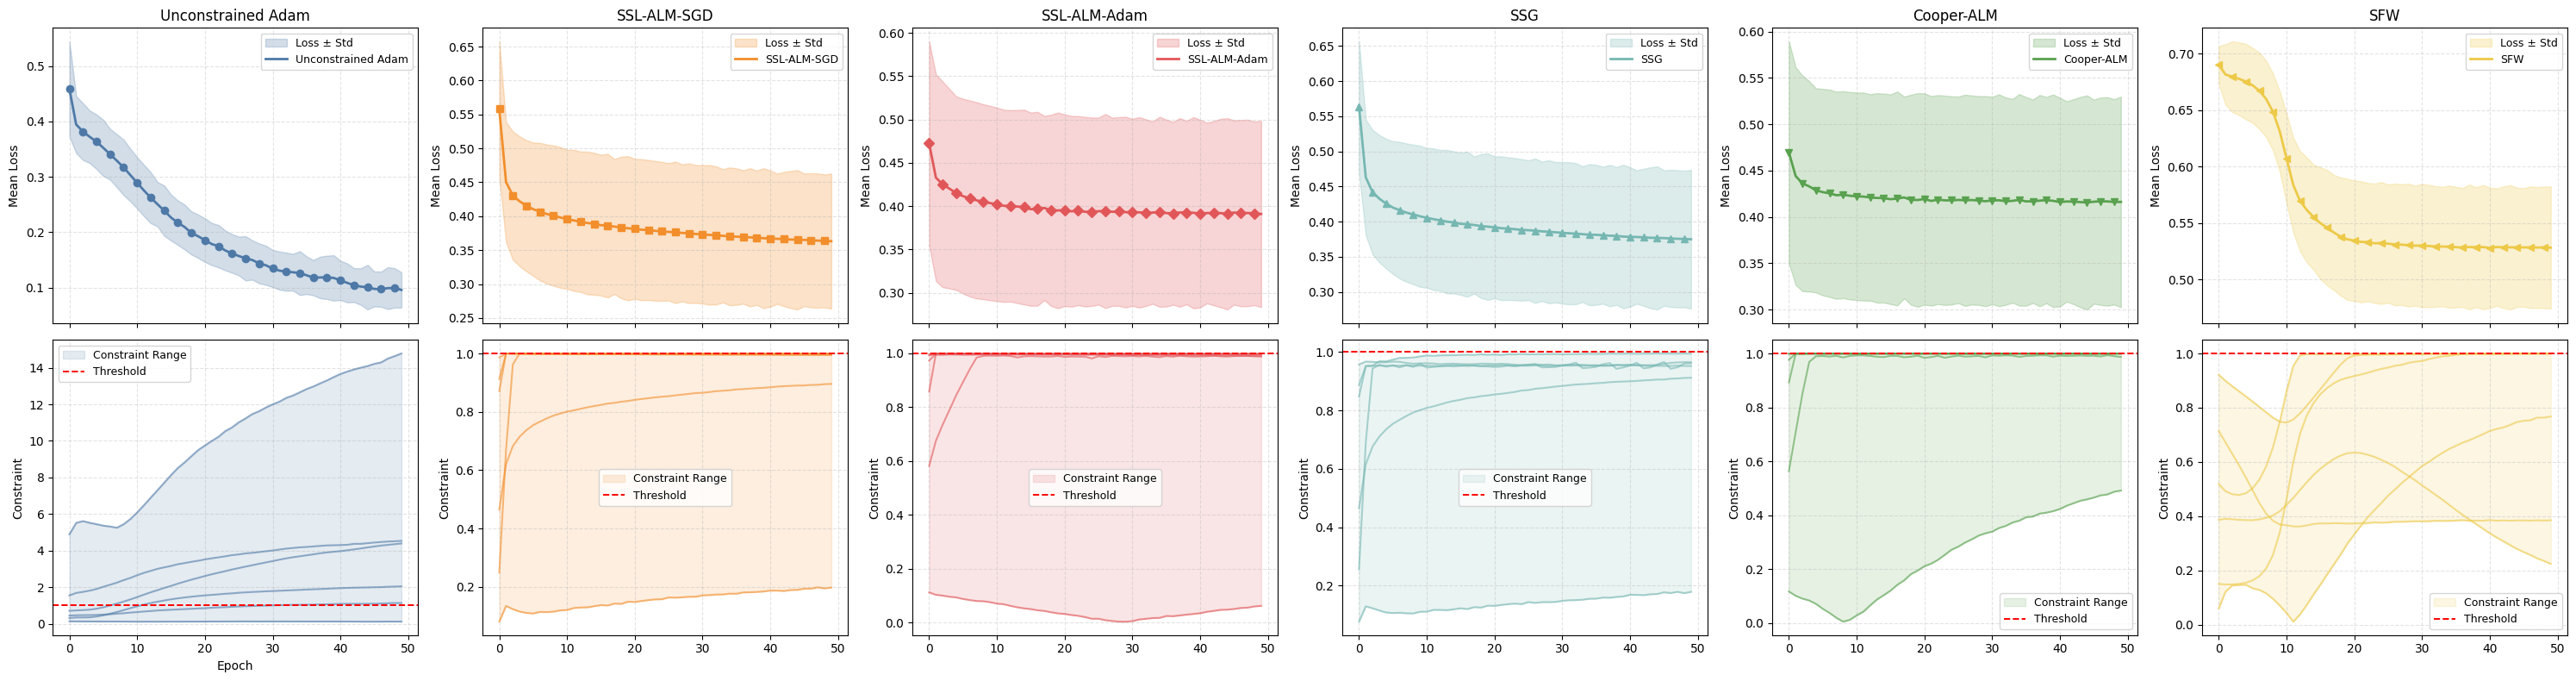

In [108]:
# plot the current results
losses = np.load(log_path)["losses"]
constraints = np.load(log_path)["constraints"]
losses_std = np.load(log_path)["losses_std"]
thresholds = [ constraint_bounds[0] ]

plot_losses_and_constraints_multi(losses, constraints, thresholds, losses_std_list=losses_std,  std_multiplier=1,
                                  titles=['Unconstrained Adam', 'SSL-ALM-SGD', 'SSL-ALM-Adam', 'SSG', 'Cooper-ALM', 'SFW'], plot_individual_constraints=True)

To better compare the results, we plot all losses in a single Figure.

In [102]:
import numpy as np
import matplotlib.pyplot as plt

def plot_losses_and_constraints_single(
    losses_list,
    losses_std_list,
    constraints_list,
    constraint_thresholds,
    titles=None,
    eval_points=2,
    std_multiplier=2,
    log_constraints=False,
    log_loss=False
):
    # --- Color palette: Tableau 10 ---
    colors = [
        "#4E79A7", "#F28E2B", "#E15759", "#76B7B2", "#59A14F",
        "#EDC948", "#B07AA1", "#FF9DA7", "#9C755F", "#BAB0AB"
    ]

    # --- Marker styles (reused from inspired function) ---
    marker_styles = ['o', 's', 'D', '^', 'v', '<', '>', 'P', 'X', '*']
    marker_styles = (marker_styles * ((len(losses_list) // len(marker_styles)) + 1))[:len(losses_list)]

    num_algos = len(losses_list)
    if titles is None:
        titles = [f"Algorithm {i+1}" for i in range(num_algos)]
    constraint_thresholds = np.atleast_1d(constraint_thresholds)

    fig, axes = plt.subplots(2, 1, figsize=(9, 11))
    ax_loss, ax_constr = axes

    # --- LOSS PLOT ---
    for j, (loss, loss_std) in enumerate(zip(losses_list, losses_std_list)):
        x = np.arange(len(loss))
        color = colors[j % len(colors)]

        if log_loss:
            loss = np.log(loss)

        upper = loss + std_multiplier * loss_std
        lower = loss - std_multiplier * loss_std

        # Mean curve
        ax_loss.plot(x, loss, lw=2.8, color=color, label=titles[j])
        # Std shading
        ax_loss.fill_between(x, lower, upper, color=color, alpha=0.09)

        # Eval points
        if eval_points is not None:
            if isinstance(eval_points, int):
                idx = np.arange(0, len(loss), eval_points)
            else:
                idx = np.array(eval_points)
                idx = idx[idx < len(loss)]
            ax_loss.plot(
                x[idx],
                loss[idx],
                marker_styles[j],
                color=color,
                markersize=7,
                alpha=0.9
            )

    ax_loss.set_ylabel("Mean Loss")
    ax_loss.set_title("Loss Comparison")
    ax_loss.grid(True, linestyle="--", alpha=0.35)
    ax_loss.legend(fontsize=9)

    # --- CONSTRAINT PLOT ---
    for j, constraints in enumerate(constraints_list):
        color = colors[j % len(colors)]

        # to make smooth constraints
        eval_points = 1

        if log_constraints:
            constraints = np.log(np.array(constraints))
        x = np.arange(constraints.shape[1])

        c_min = np.min(constraints, axis=0)
        c_max = np.max(constraints, axis=0)

        # Fill min-max range
        ax_constr.fill_between(x, c_min, c_max, color=color, alpha=0.1, label=titles[j])

        # Plot mean curves with markers
        for c_mean in constraints:
            # ax_constr.plot(x, c_mean, lw=0.3, color=color, alpha=0.01)
            if eval_points is not None:
                if isinstance(eval_points, int):
                    idx = np.arange(0, len(c_mean), eval_points)
                else:
                    idx = np.array(eval_points)
                    idx = idx[idx < len(c_mean)]
                ax_constr.plot(
                    x[idx],
                    c_mean[idx],
                    # marker_styles[j],
                    color=color,
                    # markersize=5,
                    lw=0.7,
                    alpha=0.6
                )

    # Threshold lines
    for th in constraint_thresholds:
        y = np.log(th) if log_constraints else th
        ax_constr.axhline(y, color="red", linestyle="--", lw=1.4, label="Threshold")

    ax_constr.set_ylabel("Log Constraint" if log_constraints else "Constraint")
    ax_constr.set_xlabel("Epoch")
    ax_constr.set_title("Constraint Comparison")
    ax_constr.grid(True, linestyle="--", alpha=0.35)
    ax_constr.legend(fontsize=9)

    plt.tight_layout()
    plt.show()


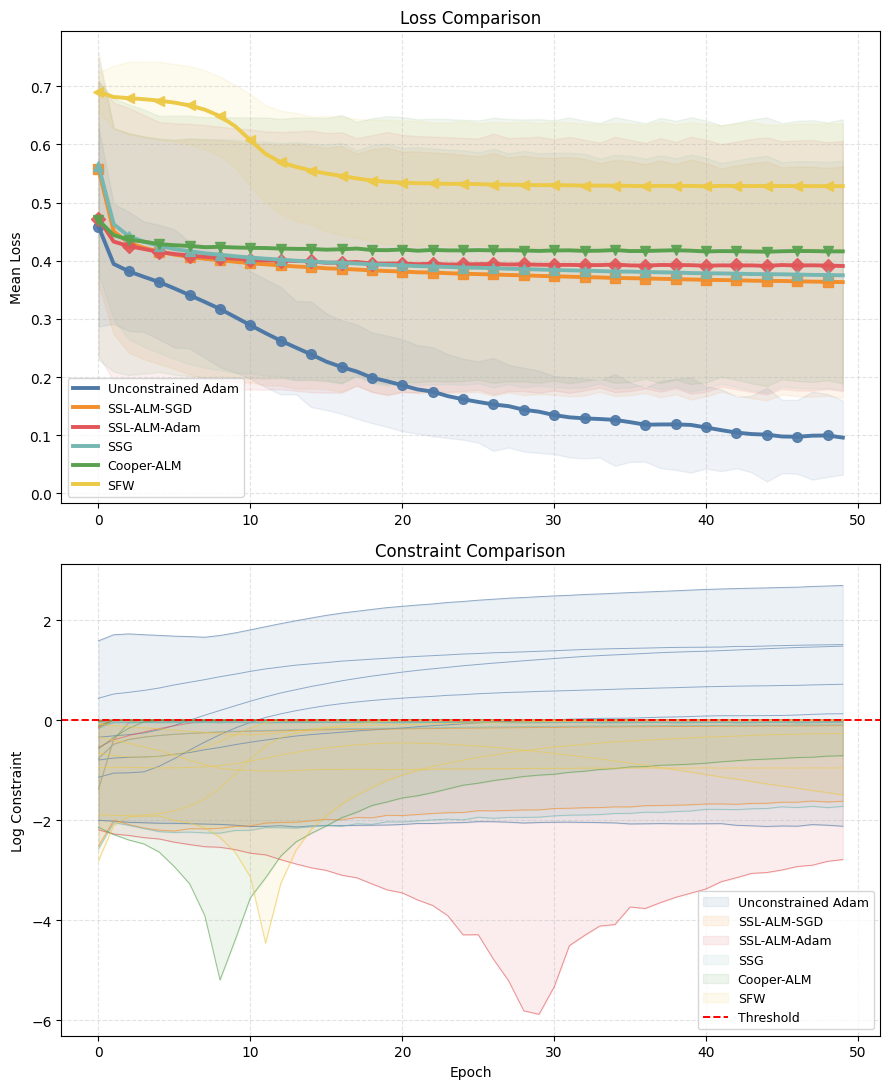

In [103]:
# plot everything into a single graph
losses = np.load(log_path)["losses"]
losses_std = np.load(log_path)["losses_std"] 
constraints = np.load(log_path)["constraints"]
thresholds = [ constraint_bounds[0] ]

plot_losses_and_constraints_single(losses, losses_std, constraints, thresholds, log_constraints=True, log_loss=False,
                                   titles=['Unconstrained Adam', 'SSL-ALM-SGD', 'SSL-ALM-Adam', 'SSG', 'Cooper-ALM', 'SFW'])

Note the unconstrained Adam is in this case superior to the constrained optimization in terms of the regression loss. This is due to the high restriction of the constraints.

# Stochastic constraints: 

To benchmark the stochastic constraints, we define the regression problem for binary classification of income above a threshold as

\begin{aligned}
& \min_{x \in \mathbb{R}^n} \; \mathbb{E}[f(x,\xi)] \\
& \text{s.t.} \quad \mathbb{E}[c(x,\zeta)] \le 0, \quad
\end{aligned}

where the $f: \mathbb{R}^n \times Ξ \rightarrow \mathbb{R}$ is a loss, the constraint $c : \mathbb{R}^n \times Z \rightarrow \mathbb{R}$ is a norm of positive rate fair metric among the sensitive groups of $S = \{$ man, woman $\}$, of size $k=2$. That is, we aim to have an unbiased regression model $g$ that has the property of

\begin{aligned}
\forall S_k \in S :\; P\big(g(x, \zeta_i) = 1 \mid S_k = 1\big)
= P\big(g(x, \zeta_i) = 1\big).
\end{aligned}

Such statistics gives us a violation vector $\bold{v} \in \mathbb{R}^k$, we define the constraint as $c(x, \zeta) = || \bold{v}(x, \zeta) ||_p$. We choose a Manhatton $p=1$. For more details about the fairness metrics see [Fairret](https://openreview.net/pdf?id=NnyD0Rjx2B). Such model should be good at classification while maintaining the fairness among sensitive demographics groups.

#### 1. Unconstrained Optimization

In [77]:
# define the torch seed here
seed_n = 1
n_epochs = 50

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# log path file
log_path = "./data/logs/log_benchmark_stochastic.npz"

In [78]:
from fairret.statistic import PositiveRate
from fairret.loss import NormLoss
from humancompatible.train.fairness.utils import BalancedBatchSampler

# get the dataset
dataset = torch.utils.data.TensorDataset(features_train, sens_train, labels_train)

# create a balanced sampling - needed for an unbiased gradient
sampler = BalancedBatchSampler(
    subgroup_onehot=sens_train,
    batch_size=128,
    drop_last=True
)
# create a dataloader from the sampler
dataloader = torch.utils.data.DataLoader(dataset, batch_sampler=sampler)

# define the criterion
criterion = torch.nn.BCEWithLogitsLoss()
statistic = PositiveRate()
fair_criterion = NormLoss(statistic=statistic)
fair_crit_bound = 0.2  # define the bound on the criterion

In [79]:
import torch
from torch.nn import Sequential

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# create small FC network
latent_size1 = 64
latent_size2 = 32
model = Sequential(
    torch.nn.Linear(features_train.shape[1], latent_size1),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size1, latent_size2),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size2, 1)
)

# create the SSLALM optimizer
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=0.001,
)

# define epochs + loss function
criterion = torch.nn.BCEWithLogitsLoss()

In [80]:
# alloc arrays for plotting
Adam_S_loss_log_plotting = [] # mean
Adam_S_c_log_plotting    = [] # mean
Adam_S_loss_std_log_plotting = [] # std
Adam_S_c_std_log_plotting = [] # std

# training loop
for epoch in range(n_epochs):
    
    # alloc the logging arrays for the batch
    loss_log = []
    c_log = []

    # go though all data
    for batch_input, batch_sens, batch_label in dataloader:
        
        # calculate constraints and constraint grads
        out = model(batch_input)
        fair_loss = fair_criterion(out, batch_sens)
        
        # calculate the fair constraint violation
        fair_constraint = fair_loss

        # save the fair loss violation for logging
        c_log.append([fair_loss.detach().item()])
        
        # calculate primal loss and grad
        loss = criterion(out, batch_label) 
        loss.backward()
        loss_log.append(loss.detach().numpy())
        optimizer.step()
        optimizer.zero_grad()

    Adam_S_c_log_plotting.append(np.mean(c_log, axis=0))
    Adam_S_loss_log_plotting.append(np.mean(loss_log))
    Adam_S_c_std_log_plotting.append(np.std(c_log, axis=0))
    Adam_S_loss_std_log_plotting.append(np.std(loss_log, axis=0))

    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
    )

Epoch: 0, loss: 0.4592224359512329, constraints: [0.1826899], 
Epoch: 1, loss: 0.3946727514266968, constraints: [0.23917505], 
Epoch: 2, loss: 0.38275301456451416, constraints: [0.25753427], 
Epoch: 3, loss: 0.3711405396461487, constraints: [0.26047066], 
Epoch: 4, loss: 0.3627611994743347, constraints: [0.26348149], 
Epoch: 5, loss: 0.35257962346076965, constraints: [0.26123586], 
Epoch: 6, loss: 0.34168747067451477, constraints: [0.26991869], 
Epoch: 7, loss: 0.33115535974502563, constraints: [0.27108348], 
Epoch: 8, loss: 0.31729456782341003, constraints: [0.27725613], 
Epoch: 9, loss: 0.3045879304409027, constraints: [0.27825432], 
Epoch: 10, loss: 0.2907879650592804, constraints: [0.28925386], 
Epoch: 11, loss: 0.2775413990020752, constraints: [0.29255645], 
Epoch: 12, loss: 0.2654717266559601, constraints: [0.29590179], 
Epoch: 13, loss: 0.25202834606170654, constraints: [0.3035675], 
Epoch: 14, loss: 0.2405117005109787, constraints: [0.30330954], 
Epoch: 15, loss: 0.230178177356

In [81]:
import numpy as np
import matplotlib.pyplot as plt

def plot_losses_and_constraints_single_stochastic(
    losses_list,
    losses_std_list,
    constraints_list,
    constraints_std_list,
    constraint_thresholds,
    titles=None,
    eval_points=2,
    std_multiplier=2,
    log_constraints=False
):
    # --- Color palette: Tableau 10 ---
    colors = [
        "#4E79A7", "#F28E2B", "#E15759", "#76B7B2", "#59A14F",
        "#EDC948", "#B07AA1", "#FF9DA7", "#9C755F", "#BAB0AB"
    ]

    # --- Marker styles (reused from inspired function) ---
    marker_styles = ['o', 's', 'D', '^', 'v', '<', '>', 'P', 'X', '*']
    marker_styles = (marker_styles * ((len(losses_list) // len(marker_styles)) + 1))[:len(losses_list)]

    num_algos = len(losses_list)
    if titles is None:
        titles = [f"Algorithm {i+1}" for i in range(num_algos)]
    constraint_thresholds = np.atleast_1d(constraint_thresholds)

    fig, axes = plt.subplots(2, 1, figsize=(9, 11))
    ax_loss, ax_constr = axes

    # --- LOSS PLOT ---
    for j, (loss, loss_std) in enumerate(zip(losses_list, losses_std_list)):
        x = np.arange(len(loss))
        color = colors[j % len(colors)]
        upper = loss + std_multiplier * loss_std
        lower = loss - std_multiplier * loss_std

        # Mean curve
        ax_loss.plot(x, loss, lw=2.2, color=color, label=titles[j])
        # Std shading
        ax_loss.fill_between(x, lower, upper, color=color, alpha=0.15)

        # Eval points
        if eval_points is not None:
            if isinstance(eval_points, int):
                idx = np.arange(0, len(loss), eval_points)
            else:
                idx = np.array(eval_points)
                idx = idx[idx < len(loss)]
            ax_loss.plot(
                x[idx],
                loss[idx],
                marker_styles[j],
                color=color,
                markersize=6,
                alpha=0.8
            )

    ax_loss.set_ylabel("Mean Loss")
    ax_loss.set_title("Loss Comparison")
    ax_loss.grid(True, linestyle="--", alpha=0.35)
    ax_loss.legend(fontsize=9)

    # --- CONSTRAINT PLOT ---
    for j, (constraints, constraints_std) in enumerate(zip(constraints_list, constraints_std_list)):
        color = colors[j % len(colors)]
        constraints = np.array(constraints)
        constraints_std = np.array(constraints_std)
        x = np.arange(constraints.shape[1])

        c_min = np.min(constraints - std_multiplier * constraints_std, axis=0)
        c_max = np.max(constraints + std_multiplier * constraints_std, axis=0)

        # Fill min-max range
        ax_constr.fill_between(x, c_min, c_max, color=color, alpha=0.15, label=titles[j])

        # Plot mean curves with markers
        for c_mean in constraints:
            ax_constr.plot(x, c_mean, lw=1.8, color=color, alpha=0.7)
            if eval_points is not None:
                if isinstance(eval_points, int):
                    idx = np.arange(0, len(c_mean), eval_points)
                else:
                    idx = np.array(eval_points)
                    idx = idx[idx < len(c_mean)]
                ax_constr.plot(
                    x[idx],
                    c_mean[idx],
                    marker_styles[j],
                    color=color,
                    markersize=5,
                    alpha=0.8
                )

    # Threshold lines
    for th in constraint_thresholds:
        y = np.log(th) if log_constraints else th
        ax_constr.axhline(y, color="red", linestyle="--", lw=1.4, label="Threshold")

    ax_constr.set_ylabel("Log Constraint" if log_constraints else "Constraint")
    ax_constr.set_xlabel("Epoch")
    ax_constr.set_title("Constraint Comparison")
    ax_constr.grid(True, linestyle="--", alpha=0.35)
    ax_constr.legend(fontsize=9)

    plt.tight_layout()
    plt.show()


In [82]:
# save the computed data
np.savez(log_path, losses=[np.array(Adam_S_loss_log_plotting)], constraints=[np.array(Adam_S_c_log_plotting).T], 
                    losses_std=[np.array(Adam_S_loss_std_log_plotting)], constraints_std=[np.array(Adam_S_c_std_log_plotting).T])

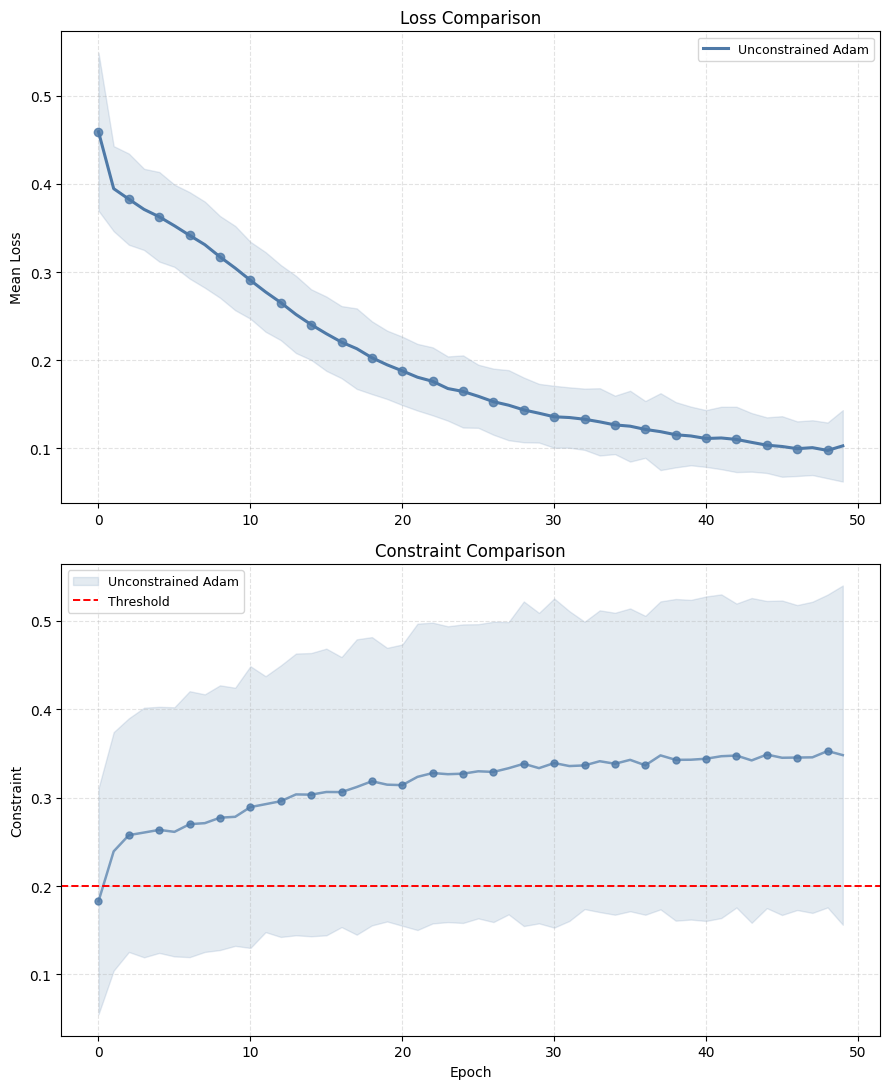

In [83]:
# plot everything into a single graph
losses = np.load(log_path)["losses"]
losses_std = np.load(log_path)["losses_std"]
constraints = np.load(log_path)["constraints"]
constraints_std = np.load(log_path)["constraints_std"]
thresholds = [ fair_crit_bound ]

plot_losses_and_constraints_single_stochastic(losses, losses_std, constraints, constraints_std, thresholds, 
                                              titles=['Unconstrained Adam'], 
                                              log_constraints=False, std_multiplier=1)

#### 2.1 SSL-ALM SGD

In [84]:
from humancompatible.train.algorithms import SSLALM
from torch.nn import Sequential

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

hsize1 = 64
hsize2 = 32
model_con = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1)
)

optimizer = SSLALM(
    params=model_con.parameters(),
    m=1, # number of constraints - one in our case
    lr=0.1, # primal variable lr
    dual_lr=0.05, # lr of a dual ALM variable
    dual_bound=5,
    rho=1, # rho penalty in ALM parameter
    mu=2, # smoothing parameter
)

# add slack variables - to create the equality from the inequalities
slack_vars = torch.zeros(1, requires_grad=True)
optimizer.add_param_group(param_group={"params": slack_vars, "name": "slack"})

In [85]:
# alloc arrays for plotting
SSLALM_SGD_S_loss_log_plotting = [] # mean
SSLALM_SGD_S_c_log_plotting    = [] # mean
SSLALM_SGD_S_loss_std_log_plotting = [] # std
SSLALM_SGD_S_c_std_log_plotting = [] # std

# training loop
for epoch in range(n_epochs):
    
    # alloc the logging arrays for the batch
    loss_log = []
    c_log = []
    duals_log = []

    # go though all data
    for batch_input, batch_sens, batch_label in dataloader:
        
        # calculate constraints and constraint grads
        out = model_con(batch_input)
        fair_loss = fair_criterion(out, batch_sens)
        
        # calculate the fair constraint violation
        fair_constraint = fair_loss + slack_vars[0] - fair_crit_bound
        fair_constraint.backward(retain_graph=True)

        # perform the dual step variable + save the dual grad for later        
        optimizer.dual_step(0, c_val=fair_constraint)
        optimizer.zero_grad()

        # save the fair loss violation for logging
        c_log.append([fair_loss.detach().item()])
        duals_log.append(optimizer._dual_vars.detach())
        
        # calculate primal loss and grad
        loss = criterion(out, batch_label) + 0 * slack_vars[0] # need to add 0*slack variables for autograd to work
        loss.backward()
        loss_log.append(loss.detach().numpy())
        optimizer.step()
        optimizer.zero_grad()

        # slack variables must be non-negative. this is the "projection" step from the SSL-ALM paper
        with torch.no_grad():
            for s in slack_vars:
                if s < 0:
                    s.zero_()
        
    optimizer.dual_lr *= 0.95
    SSLALM_SGD_S_c_log_plotting.append(np.mean(c_log, axis=0))
    SSLALM_SGD_S_loss_log_plotting.append(np.mean(loss_log))
    SSLALM_SGD_S_c_std_log_plotting.append(np.std(c_log, axis=0))
    SSLALM_SGD_S_loss_std_log_plotting.append(np.std(loss_log, axis=0))

    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
        f"dual: {np.mean(duals_log, axis=0)}"
    )

Epoch: 0, loss: 0.5476123690605164, constraints: [0.07866101], dual: [0.00845639]
Epoch: 1, loss: 0.4131006598472595, constraints: [0.18581737], dual: [0.03697782]
Epoch: 2, loss: 0.394643098115921, constraints: [0.19702015], dual: [0.07289013]
Epoch: 3, loss: 0.38410887122154236, constraints: [0.19430995], dual: [0.09832019]
Epoch: 4, loss: 0.37728992104530334, constraints: [0.19308986], dual: [0.07235397]
Epoch: 5, loss: 0.3715454339981079, constraints: [0.19137347], dual: [0.075288]
Epoch: 6, loss: 0.36716997623443604, constraints: [0.19032816], dual: [0.04052112]
Epoch: 7, loss: 0.36228394508361816, constraints: [0.19502162], dual: [0.05839768]
Epoch: 8, loss: 0.35755595564842224, constraints: [0.19642572], dual: [0.06575448]
Epoch: 9, loss: 0.3538602590560913, constraints: [0.19339319], dual: [0.04550575]
Epoch: 10, loss: 0.3490326702594757, constraints: [0.1991729], dual: [0.08412839]
Epoch: 11, loss: 0.3447719216346741, constraints: [0.19906746], dual: [0.10788523]
Epoch: 12, lo

In [86]:
# load the prior and append
losses = list(np.load(log_path)["losses"])
constraints = list(np.load(log_path)["constraints"])
losses_std = list(np.load(log_path)["losses_std"]) 
constraints_std = list(np.load(log_path)["constraints_std"]) 

# append
losses += [np.array(SSLALM_SGD_S_loss_log_plotting)]
constraints += [np.array(SSLALM_SGD_S_c_log_plotting).T]
losses_std += [np.array(SSLALM_SGD_S_loss_std_log_plotting)]
constraints_std += [np.array(SSLALM_SGD_S_c_std_log_plotting).T]

# save the computed data
np.savez(log_path, losses=losses, constraints=constraints, losses_std=losses_std, constraints_std=constraints_std)

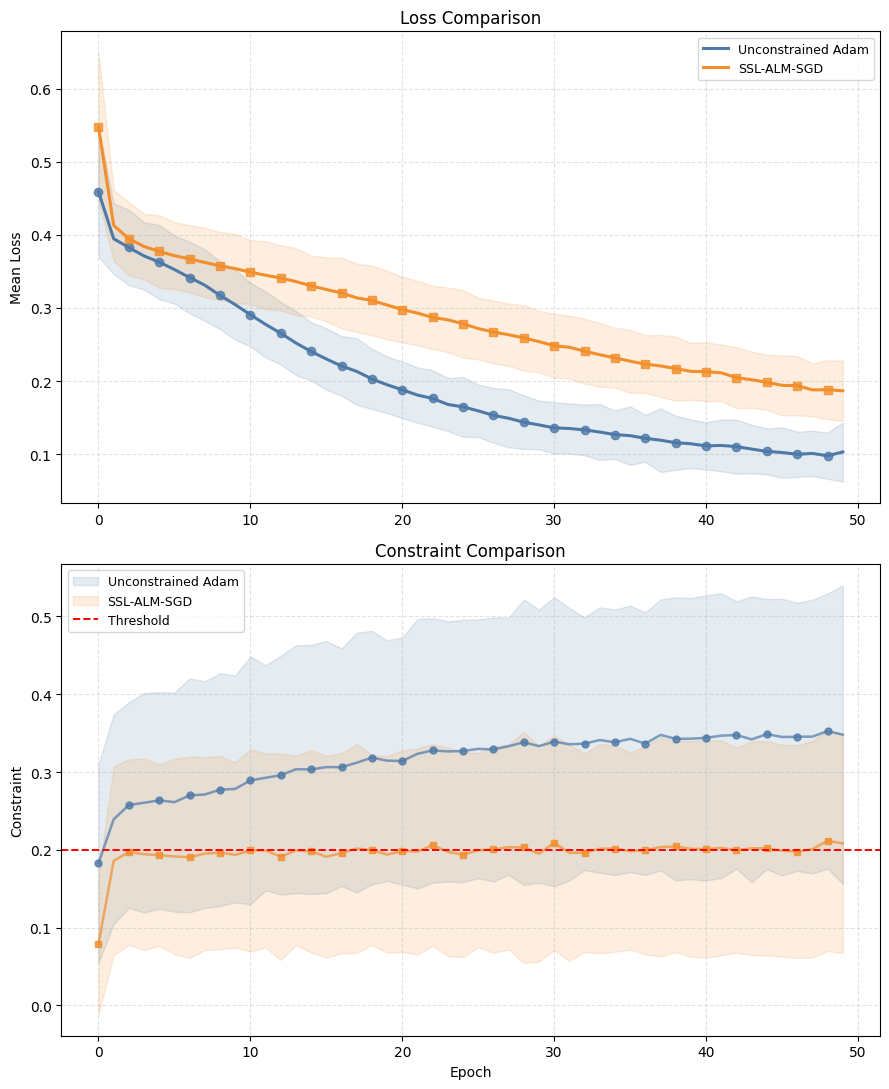

In [87]:
# plot everything into a single graph
losses = np.load(log_path)["losses"]
losses_std = np.load(log_path)["losses_std"]
constraints = np.load(log_path)["constraints"]
constraints_std = np.load(log_path)["constraints_std"]
thresholds = [ fair_crit_bound ]

plot_losses_and_constraints_single_stochastic(losses, losses_std, constraints, constraints_std, thresholds, titles=['Unconstrained Adam', 'SSL-ALM-SGD'], log_constraints=False, std_multiplier=1)

#### 2.2 SSL-ALM Adam

In [88]:
from torch.nn import Sequential
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.humancompatible.train.optim.ssl_alm_adam import SSLALM_Adam

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

hsize1 = 64
hsize2 = 32
model_con = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1)
)

optimizer = SSLALM_Adam(
    params=model_con.parameters(),
    m=1, # number of constraints - one in our case
    lr=0.01, # primal variable lr
    dual_lr=0.05, # lr of a dual ALM variable
    dual_bound=5,
    rho=1, # rho penalty in ALM parameter
    mu=2, # smoothing parameter
)

# add slack variables - to create the equality from the inequalities
slack_vars = torch.zeros(1, requires_grad=True)
optimizer.add_param_group(param_group={"params": slack_vars, "name": "slack"})

In [89]:
# alloc arrays for plotting
SSLALM_S_loss_log_plotting = [] # mean
SSLALM_S_c_log_plotting    = [] # mean
SSLALM_S_loss_std_log_plotting = [] # std
SSLALM_S_c_std_log_plotting = [] # std

# training loop
for epoch in range(n_epochs):
    
    # alloc the logging arrays for the batch
    loss_log = []
    c_log = []
    duals_log = []

    # go though all data
    for batch_input, batch_sens, batch_label in dataloader:
        
        # calculate constraints and constraint grads
        out = model_con(batch_input)
        fair_loss = fair_criterion(out, batch_sens)
        
        # calculate the fair constraint violation
        fair_constraint = fair_loss + slack_vars[0] - fair_crit_bound
        fair_constraint.backward(retain_graph=True)

        # perform the dual step variable + save the dual grad for later        
        optimizer.dual_step(0, c_val=fair_constraint)
        optimizer.zero_grad()

        # save the fair loss violation for logging
        c_log.append([fair_loss.detach().item()])
        duals_log.append(optimizer._dual_vars.detach())
        
        # calculate primal loss and grad
        loss = criterion(out, batch_label) + 0* slack_vars[0]
        loss.backward()
        loss_log.append(loss.detach().numpy())
        optimizer.step()
        optimizer.zero_grad()

        # slack variables must be non-negative. this is the "projection" step from the SSL-ALM paper
        with torch.no_grad():
            for s in slack_vars:
                if s < 0:
                    s.zero_()
        
    optimizer.dual_lr *= 0.95
    SSLALM_S_c_log_plotting.append(np.mean(c_log, axis=0))
    SSLALM_S_loss_log_plotting.append(np.mean(loss_log))
    SSLALM_S_c_std_log_plotting.append(np.std(c_log, axis=0))
    SSLALM_S_loss_std_log_plotting.append(np.std(loss_log, axis=0))

    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
        f"dual: {np.mean(duals_log, axis=0)}"
    )

Epoch: 0, loss: 0.4735445976257324, constraints: [0.14126119], dual: [0.00236604]
Epoch: 1, loss: 0.4003300070762634, constraints: [0.19756161], dual: [0.03587616]
Epoch: 2, loss: 0.38659578561782837, constraints: [0.20250662], dual: [0.06765646]
Epoch: 3, loss: 0.376892626285553, constraints: [0.20180443], dual: [0.09345168]
Epoch: 4, loss: 0.36981266736984253, constraints: [0.19787789], dual: [0.0698868]
Epoch: 5, loss: 0.3627416491508484, constraints: [0.19944552], dual: [0.07329166]
Epoch: 6, loss: 0.35689303278923035, constraints: [0.19491077], dual: [0.02459923]
Epoch: 7, loss: 0.3503275215625763, constraints: [0.20148703], dual: [0.04691381]
Epoch: 8, loss: 0.34307992458343506, constraints: [0.20305414], dual: [0.07508791]
Epoch: 9, loss: 0.33702337741851807, constraints: [0.19652639], dual: [0.04470544]
Epoch: 10, loss: 0.3291666507720947, constraints: [0.20629361], dual: [0.09744155]
Epoch: 11, loss: 0.32286983728408813, constraints: [0.2004008], dual: [0.10061289]
Epoch: 12, 

In [90]:
# load the prior and append
losses = list(np.load(log_path)["losses"])
constraints = list(np.load(log_path)["constraints"])
losses_std = list(np.load(log_path)["losses_std"]) 
constraints_std = list(np.load(log_path)["constraints_std"]) 

# append
losses += [np.array(SSLALM_S_loss_log_plotting)]
constraints += [np.array(SSLALM_S_c_log_plotting).T]
losses_std += [np.array(SSLALM_S_loss_std_log_plotting)]
constraints_std += [np.array(SSLALM_S_c_std_log_plotting).T]

# save the computed data
np.savez(log_path, losses=losses, constraints=constraints, losses_std=losses_std, constraints_std=constraints_std)

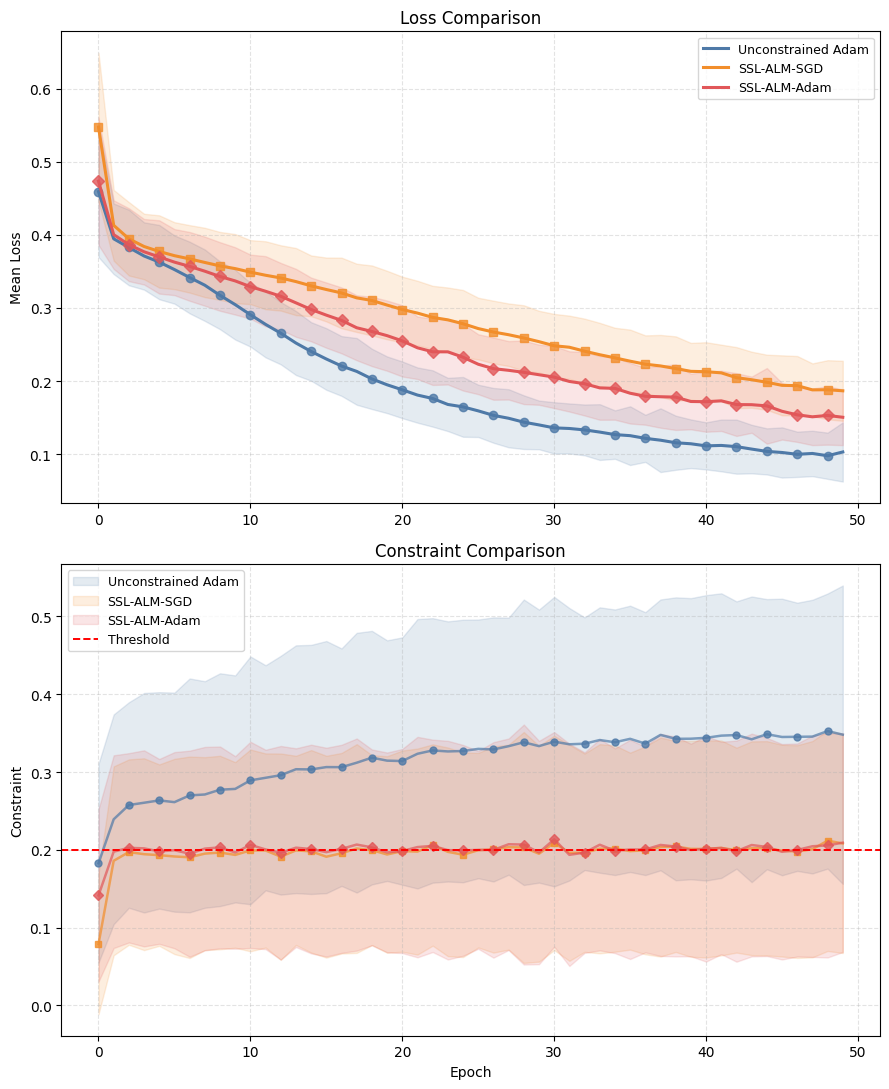

In [91]:
# plot everything into a single graph
losses = np.load(log_path)["losses"]
losses_std = np.load(log_path)["losses_std"]
constraints = np.load(log_path)["constraints"]
constraints_std = np.load(log_path)["constraints_std"]
thresholds = [ fair_crit_bound ]

plot_losses_and_constraints_single_stochastic(losses, losses_std, constraints, constraints_std, thresholds, 
                                              titles=['Unconstrained Adam', 'SSL-ALM-SGD', 'SSL-ALM-Adam'], 
                                              log_constraints=False, std_multiplier=1)

#### 3. Switching-Subgradient

In [92]:
from fairret.statistic import PositiveRate
from fairret.loss import NormLoss
from humancompatible.train.fairness.utils import BalancedBatchSampler

# get the dataset
dataset = torch.utils.data.TensorDataset(features_train, sens_train, labels_train)

# create a balanced sampling - needed for an unbiased gradient
sampler = BalancedBatchSampler(
    subgroup_onehot=sens_train,
    batch_size=128,
    drop_last=True
)

# create a dataloader from the sampler
dataloader = torch.utils.data.DataLoader(dataset, batch_sampler=sampler)

# define the criterion
criterion = torch.nn.BCEWithLogitsLoss()
statistic = PositiveRate()
fair_criterion = NormLoss(statistic=statistic)
fair_crit_bound = 0.2

In [93]:
from humancompatible.train.algorithms import SSG
from torch.nn import Sequential

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# same network size for all algorithms
hsize1 = 64
hsize2 = 32
model_con = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1)
)

optimizer = SSG(
    params=model_con.parameters(),
    m=1,
    lr=0.1,
    dual_lr=0.05
)

In [94]:
# alloc arrays for plotting
SSG_S_loss_log_plotting = [] # mean
SSG_S_c_log_plotting    = [] # mean
SSG_S_loss_std_log_plotting = [] # std
SSG_S_c_std_log_plotting = [] # std

# training loop
for epoch in range(n_epochs):

    # alloc the logging arrays for the batch
    loss_log = []
    c_log = []
    duals_log = []

    # go though all data
    for batch_input, batch_sens, batch_label in dataloader:

        # calculate constraints and constraint grads
        out = model_con(batch_input)
        fair_loss = fair_criterion(out, batch_sens)
        fair_constraint = torch.max(fair_loss - fair_crit_bound, torch.zeros(1))
        fair_constraint.backward(retain_graph=True)
        
        # compute the grad of the constraints
        optimizer.dual_step(0)
        optimizer.zero_grad()

        # save the constraint value
        c_log.append([fair_loss.detach().item()])
        
        # calculate loss and grad
        loss = criterion(out, batch_label)
        loss.backward()
        loss_log.append(loss.detach().numpy())
        optimizer.step(fair_constraint)
        optimizer.zero_grad()
        
        
    SSG_S_c_log_plotting.append(np.mean(c_log, axis=0))
    SSG_S_loss_log_plotting.append(np.mean(loss_log))
    SSG_S_c_std_log_plotting.append(np.std(c_log, axis=0))
    SSG_S_loss_std_log_plotting.append(np.std(loss_log, axis=0))
    
    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
    )

Epoch: 0, loss: 0.522874653339386, constraints: [0.08450851], 
Epoch: 1, loss: 0.42589524388313293, constraints: [0.12982562], 
Epoch: 2, loss: 0.40672022104263306, constraints: [0.14047133], 
Epoch: 3, loss: 0.3998394012451172, constraints: [0.12920718], 
Epoch: 4, loss: 0.39344871044158936, constraints: [0.1378811], 
Epoch: 5, loss: 0.388198584318161, constraints: [0.12967816], 
Epoch: 6, loss: 0.3840477466583252, constraints: [0.13636403], 
Epoch: 7, loss: 0.3800334930419922, constraints: [0.1344014], 
Epoch: 8, loss: 0.3772767186164856, constraints: [0.13726422], 
Epoch: 9, loss: 0.3723162114620209, constraints: [0.13584391], 
Epoch: 10, loss: 0.36924779415130615, constraints: [0.14337963], 
Epoch: 11, loss: 0.3664214015007019, constraints: [0.13781949], 
Epoch: 12, loss: 0.3654307425022125, constraints: [0.13988721], 
Epoch: 13, loss: 0.3608675003051758, constraints: [0.14370849], 
Epoch: 14, loss: 0.3568142056465149, constraints: [0.1382025], 
Epoch: 15, loss: 0.3536081612110138,

In [95]:
# load the prior and append
losses = list(np.load(log_path)["losses"])
constraints = list(np.load(log_path)["constraints"])
losses_std = list(np.load(log_path)["losses_std"]) 
constraints_std = list(np.load(log_path)["constraints_std"]) 

# append
losses += [np.array(SSG_S_loss_log_plotting)]
constraints += [np.array(SSG_S_c_log_plotting).T]
losses_std += [np.array(SSG_S_loss_std_log_plotting)]
constraints_std += [np.array(SSG_S_c_std_log_plotting).T]

# save the computed data
np.savez(log_path, losses=losses, constraints=constraints, losses_std=losses_std, constraints_std=constraints_std)

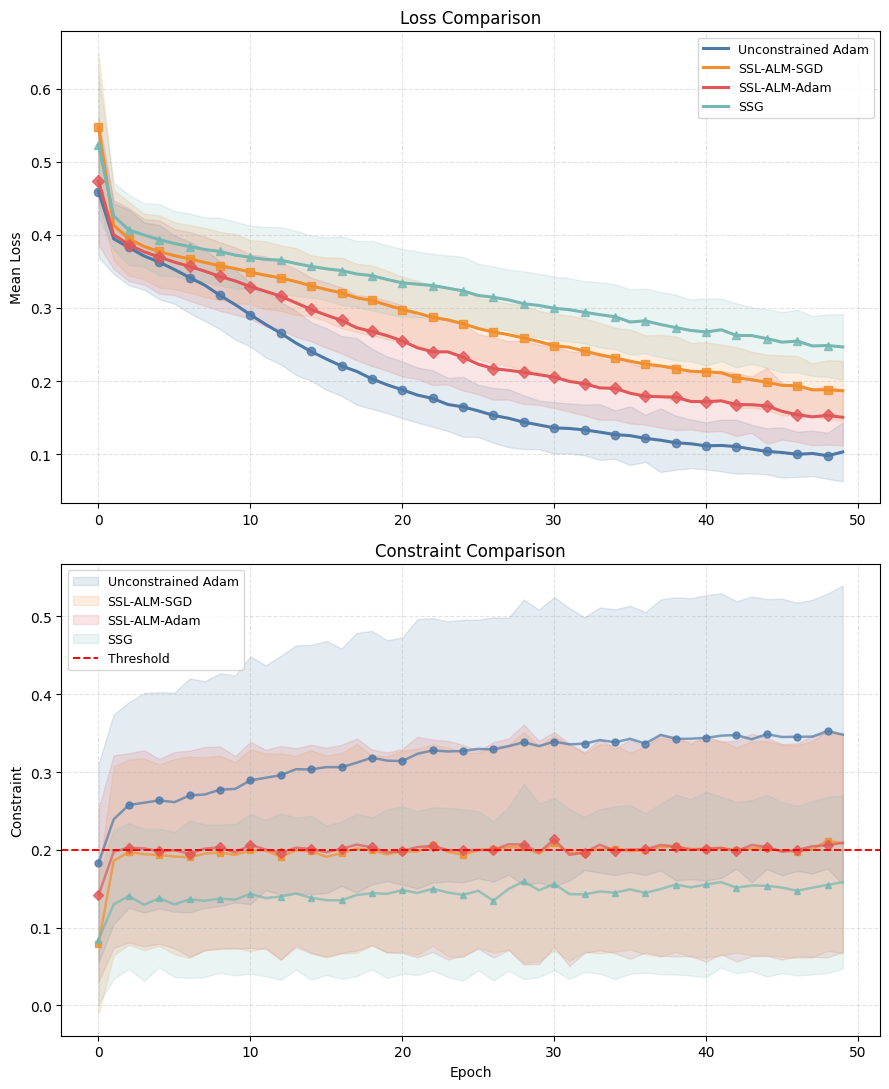

In [96]:
# plot everything into a single graph
losses = np.load(log_path)["losses"]
losses_std = np.load(log_path)["losses_std"]
constraints = np.load(log_path)["constraints"]
constraints_std = np.load(log_path)["constraints_std"]
thresholds = [ fair_crit_bound ]

plot_losses_and_constraints_single_stochastic(losses, losses_std, constraints, constraints_std, thresholds, 
                                              titles=['Unconstrained Adam', 'SSL-ALM-SGD', 'SSL-ALM-Adam', "SSG"], 
                                              log_constraints=False, std_multiplier=1)

#### 4. Cooper - Augmented Lagrangian

In [97]:
from fairret.statistic import PositiveRate
from fairret.loss import NormLoss
from humancompatible.train.fairness.utils import BalancedBatchSampler

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# get the dataset
dataset = torch.utils.data.TensorDataset(features_train, sens_train, labels_train)

# create a balanced sampling - needed for an unbiased gradient
sampler = BalancedBatchSampler(
    subgroup_onehot=sens_train,
    batch_size=128,
    drop_last=True
)

# create a dataloader from the sampler
dataloader = torch.utils.data.DataLoader(dataset, batch_sampler=sampler)

# define the criterion
criterion = torch.nn.BCEWithLogitsLoss()
statistic = PositiveRate()
fair_criterion = NormLoss(statistic=statistic)
fair_crit_bound = 0.2

In [98]:
import torch
from torch.nn import Sequential

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# create small FC network
latent_size1 = 64
latent_size2 = 32
model = Sequential(
    torch.nn.Linear(features_train.shape[1], latent_size1),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size1, latent_size2),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size2, 1)
)

# define epochs + loss function
criterion = torch.nn.BCEWithLogitsLoss()

In [99]:
import cooper

# select device
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # define GPU if available
DEVICE = "cpu"

# define the problem
class ACS_Deterministic_Constr_Fair_ALM(cooper.ConstrainedMinimizationProblem):
    def __init__(self, formulation_type):
        super().__init__()

        # define the number of multipliers - same as the number of constraints
        if not formulation_type.expects_multiplier:
            self.multiplier = None
        else:
            self.multiplier = cooper.multipliers.DenseMultiplier(num_constraints=1, device=DEVICE) 

        # add the penalty coefficient - augmented lagrangian
        if not formulation_type.expects_penalty_coefficient:
            self.penalty = None
        else:
            self.penalty = cooper.penalty_coefficients.DensePenaltyCoefficient(
                init=torch.tensor(1.0, device=DEVICE),
            )
        
        # inequality constraints on the norm of the matrix
        self.constraint = cooper.Constraint(
            constraint_type=cooper.ConstraintType.INEQUALITY,
            formulation_type=formulation_type,
            multiplier=self.multiplier,
            penalty_coefficient=self.penalty,
        )


    # function that computes the constraints and the loss function
    def compute_cmp_state(self, model, inputs, targets, batch_sens):

        # compute the yhat loss
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        out = model(inputs)
        loss = criterion( out , targets )

        # compute fair metric
        fair_loss = fair_criterion(out, batch_sens)
        fair_constraint = fair_loss - fair_crit_bound
        
        # compute the constraint violation
        constraint_state = cooper.ConstraintState(violation=fair_constraint)
        observed_constraints = {self.constraint: constraint_state}

        return cooper.CMPState(loss=loss, observed_constraints=observed_constraints)


In [100]:
# create the problem
problem = ACS_Deterministic_Constr_Fair_ALM(cooper.formulations.AugmentedLagrangian)

# flag of dual variables
has_dual_variables = problem.multiplier is not None

# create the primal optimizer
primal_optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# create the dual optimizer
if has_dual_variables:
    dual_optimizer = torch.optim.SGD(problem.dual_parameters(), lr=0.05, maximize=True)

    # combine the optimizers
    constrained_optimizer = cooper.optim.SimultaneousOptimizer(
        cmp=problem,
        primal_optimizers=primal_optimizer,
        dual_optimizers=dual_optimizer,
    )
else:
    # Formulations without dual variables, such as the Quadratic Penalty
    # formulation, do not require a dual optimizer
    constrained_optimizer = cooper.optim.UnconstrainedOptimizer(
        cmp=problem,
        primal_optimizers=primal_optimizer,
    )

# Increase the penalty coefficient by `increment` if the constraint is violate by more
# than `violation_tolerance`- keep this the same - since its not included in SSL-ALM implementation
penalty_scheduler = cooper.penalty_coefficients.AdditivePenaltyCoefficientUpdater(
    increment=0.0, 
    violation_tolerance=1e-3,
)

In [101]:
# alloc arrays for plotting
Cooper_S_c_log_plotting    = []
Cooper_S_loss_log_plotting = []
Cooper_S_loss_std_log_plotting = []
Cooper_S_c_std_log_plotting = []

# training loop
for epoch in range(n_epochs):

    # alloc the logging arrays
    loss_log = []
    c_log = []
    duals_log = []
    penalty_coefficient_values = []

    # alloc norm values array
    norm_values_c = []

    # go through all data
    for batch_input, batch_sens, batch_label in dataloader:

        # calculate the constraints - for logging purposes
        out = model(batch_input)
        fair_loss = fair_criterion(out, batch_sens)
        fair_constraint = fair_loss - fair_crit_bound
        c_log.append([fair_loss.detach().item()])

        # compute the loss - just for logging purposes
        loss = criterion( out , batch_label )
        loss_log.append(loss.item())

        # compute the states
        compute_cmp_state_kwargs = {"model": model, "inputs": batch_input, 
                                    "targets": batch_label, "batch_sens": batch_sens}
        roll_out = constrained_optimizer.roll(compute_cmp_state_kwargs=compute_cmp_state_kwargs)

        # Update the penalty coefficient
        constraint_state = roll_out.cmp_state.observed_constraints[problem.constraint]
        penalty_scheduler.update_penalty_coefficient_(problem.constraint, constraint_state)

        # get the dual variables and the coefficients
        multiplier_value = problem.multiplier.weight.detach().numpy() if has_dual_variables else None
        penalty_coefficient_value = problem.constraint.penalty_coefficient().item()

        # save the duals and penalty coefficients
        duals_log.append(multiplier_value)
        penalty_coefficient_values.append(penalty_coefficient_value)

    # save the epoch values for plotting
    Cooper_S_loss_log_plotting.append(np.mean(loss_log))
    Cooper_S_c_log_plotting.append(np.mean(c_log, axis=0))
    Cooper_S_c_std_log_plotting.append(np.std(c_log, axis=0))
    Cooper_S_loss_std_log_plotting.append(np.std(loss_log, axis=0))

    # print out the epoch values
    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
        f"dual: {np.mean(duals_log, axis=0)}, "
        f"penalty coefficients: {np.mean(penalty_coefficient_values, axis=0)}, "
    )
    

Epoch: 0, loss: 0.4444855982236725, constraints: [0.17635845], dual: [0.0078749], penalty coefficients: 1.0, 
Epoch: 1, loss: 0.40838247044480963, constraints: [0.19060089], dual: [0.01945601], penalty coefficients: 1.0, 
Epoch: 2, loss: 0.39648603717629, constraints: [0.19798113], dual: [0.02770164], penalty coefficients: 1.0, 
Epoch: 3, loss: 0.3840197484484679, constraints: [0.19759223], dual: [0.038512], penalty coefficients: 1.0, 
Epoch: 4, loss: 0.37782849510796634, constraints: [0.18990761], dual: [0.04529574], penalty coefficients: 1.0, 
Epoch: 5, loss: 0.3691690169114003, constraints: [0.19361369], dual: [0.01884324], penalty coefficients: 1.0, 
Epoch: 6, loss: 0.3609591740176832, constraints: [0.19451166], dual: [0.04921701], penalty coefficients: 1.0, 
Epoch: 7, loss: 0.35403930722809523, constraints: [0.19934679], dual: [0.04334942], penalty coefficients: 1.0, 
Epoch: 8, loss: 0.3472038838181564, constraints: [0.19997339], dual: [0.04681811], penalty coefficients: 1.0, 
Epo

In [102]:
# load the prior and append
losses = list(np.load(log_path)["losses"])
constraints = list(np.load(log_path)["constraints"])
losses_std = list(np.load(log_path)["losses_std"]) 
constraints_std = list(np.load(log_path)["constraints_std"]) 

# append
losses += [np.array(Cooper_S_loss_log_plotting)]
constraints += [np.array(Cooper_S_c_log_plotting).T]
losses_std += [np.array(Cooper_S_loss_std_log_plotting)]
constraints_std += [np.array(Cooper_S_c_std_log_plotting).T]

# save the computed data
np.savez(log_path, losses=losses, constraints=constraints, losses_std=losses_std, constraints_std=constraints_std)

#### Results

Now we plot all results in a single table to compare all algorithms.

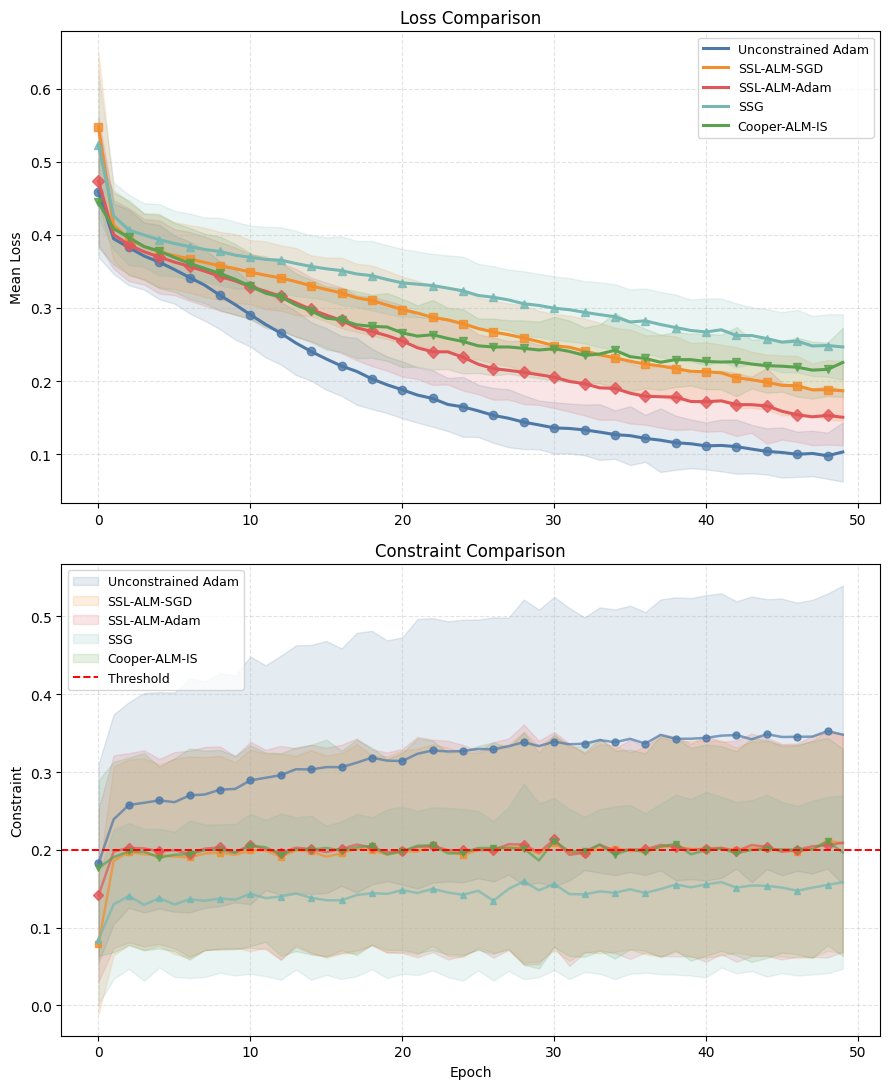

In [103]:
# plot everything into a single graph
losses = np.load(log_path)["losses"]
losses_std = np.load(log_path)["losses_std"]
constraints = np.load(log_path)["constraints"]
constraints_std = np.load(log_path)["constraints_std"]
thresholds = [ fair_crit_bound ]

plot_losses_and_constraints_single_stochastic(losses, losses_std, constraints, constraints_std, thresholds, 
                                              titles=['Unconstrained Adam', 'SSL-ALM-SGD', 'SSL-ALM-Adam', "SSG", "Cooper-ALM-IS"], 
                                              log_constraints=False, std_multiplier=1)

It is interesting to see that in the stochastic case, the constraints are not as restrictive as in the deterministic case, directly implying the small difference in the loss between the Unconstrained Adam and the best constrained SSL-ALM-Adam.

# Importance Sampling

the importance of balanced sampling gradient\

In [94]:
# define the torch seed here
seed_n = 1
n_epochs = 10

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# log path file
log_path = "./data/logs/log_benchmark_stochastic_importance_sampling.npz"

In [95]:
# load and prepare data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import numpy as np
from folktables import ACSDataSource, ACSIncome, generate_categories

# load folktables data
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["VA"], download=True)
definition_df = data_source.get_definitions(download=True)
categories = generate_categories(features=ACSIncome.features, definition_df=definition_df)
df_feat, df_labels, _ = ACSIncome.df_to_pandas(acs_data,categories=categories, dummies=True)

# split the data on groups, labels and features - the features should not have the sensitive feature
sens_cols = ['SEX_Female', 'SEX_Male']
features = df_feat.drop(columns=sens_cols).to_numpy(dtype="float")
groups = df_feat[sens_cols].to_numpy(dtype="float")
labels = df_labels.to_numpy(dtype="float")

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# split
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    features, labels, groups, test_size=0.4, random_state=42)

# scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Now we create 3 dataloaders:

- train unbalanced dataloader - unbalanced in the sense that each batch is not guaranteed to have the same number of samples of sensitive subgroups - leading to a biased gradient of the constraint
- train balanaced dataloader
- test dataloader - to see how the two above compare

In [96]:
# define the batch sizes testing array
batch_sizes = [32, 64]

# samplers array
unbalanced_samplers = []
balanced_samplers   = []
test_samplers       = []

# tensor the train data
features_train = torch.tensor(X_train, dtype=torch.float32)
labels_train = torch.tensor(y_train,dtype=torch.float32)
sens_train = torch.tensor(groups_train)

# tensor the test data
features_test = torch.tensor(X_test, dtype=torch.float32)
labels_test = torch.tensor(y_test,dtype=torch.float32)
sens_test = torch.tensor(groups_test)

# create a train dataset
dataset_train = torch.utils.data.TensorDataset(features_train, sens_train, labels_train)

# create test dataset
dataset_test = torch.utils.data.TensorDataset(features_test, sens_test, labels_test)

# create samplers for each batchsize
for batch_size in batch_sizes:

    # create the unbalanced dataloader
    unbalanced_dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    unbalanced_samplers += [unbalanced_dataloader]

    # create the balanced dataloader
    sampler = BalancedBatchSampler(
        subgroup_onehot=sens_train,
        batch_size=batch_size,
        drop_last=True
    )
    balanced_sampler = torch.utils.data.DataLoader(dataset_train, batch_sampler=sampler)
    balanced_samplers += [balanced_sampler]

    # create test dataloader
    test_sampler = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)
    test_samplers += [test_sampler]


Define the fairness constraint to be the same as in the stochastic benchmarking

In [88]:
from fairret.statistic import PositiveRate
from fairret.loss import NormLoss
from humancompatible.train.fairness.utils import BalancedBatchSampler

# define the fairness criterion
criterion = torch.nn.BCEWithLogitsLoss()
statistic = PositiveRate()
fair_criterion = NormLoss(statistic=statistic)
fair_crit_bound = 0.2  # define the bound on the criterion


Define the test function

In [89]:
def test_model_fairness(model_to_test, test_sampler, fair_criterion):
    """Test the model fairness on the test dataset"""

    fair_constr = []
    fair_constr_woman = []
    fair_constr_men = []

    with torch.no_grad():

        # go though all test data
        for batch_input, batch_sens, _ in test_sampler:

            # compute the fairness loss
            out = model_to_test(batch_input)
            fair_loss = fair_criterion(out, batch_sens) # sigmoid is implicit here

            # compute the fairness per group
            preds = torch.nn.functional.sigmoid(out)
            pr = PositiveRate()
            woman_constr, men_constr = pr(preds, batch_sens) # P(y=1|Sk = 1)
            overall = PositiveRate().overall_statistic(preds) # take the P(y=1)
            woman_constr = torch.abs(woman_constr / overall - 1.0)
            men_constr = torch.abs(men_constr / overall - 1.0)

            # save the data 
            fair_constr += [fair_loss.detach().item()] 
            fair_constr_woman += [woman_constr.detach().item()]
            fair_constr_men += [men_constr.detach().item()]

        fair_constr = np.array(fair_constr)
        fair_constr_woman = np.array(fair_constr_woman)
        fair_constr_men = np.array(fair_constr_men)

    return (fair_constr.mean(), fair_constr.std()), (fair_constr_woman.mean(), fair_constr_woman.std()), (fair_constr_men.mean(), fair_constr_men.std())

#### 1. Balanced sampling
Train-test the SSL-ALM-Adam with the balanced sampler

In [ ]:
from torch.nn import Sequential
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.humancompatible.train.optim.ssl_alm_adam import SSLALM_Adam
import copy

# alloc arrays for plotting
balanced_losses_train       = [[] for _ in range(len(batch_sizes))]
balanced_const_train        = [[] for _ in range(len(batch_sizes))]
balanced_constr_test        = [[] for _ in range(len(batch_sizes))]
balanced_constr_test_men    = [[] for _ in range(len(batch_sizes))]
balanced_constr_test_woman  = [[] for _ in range(len(batch_sizes))]

for batch_size_idx, balanced_sampler in enumerate(balanced_samplers):

    print(f"BATCH SIZE TESTING: {batch_sizes[batch_size_idx]}\n")

    ################################### INIT THE MODEL ############################################

    # set the same seed for fair comparisons
    torch.manual_seed(seed_n)

    hsize1 = 64
    hsize2 = 32
    model_con = Sequential(
        torch.nn.Linear(features_train.shape[1], hsize1),
        torch.nn.ReLU(),
        torch.nn.Linear(hsize1, hsize2),
        torch.nn.ReLU(),
        torch.nn.Linear(hsize2, 1)
    )

    optimizer = SSLALM_Adam(
        params=model_con.parameters(),
        m=1, # number of constraints - one in our case
        lr=0.01, # primal variable lr
        dual_lr=0.05, # lr of a dual ALM variable
        dual_bound=5,
        rho=1, # rho penalty in ALM parameter
        mu=2, # smoothing parameter
    )

    # add slack variables - to create the equality from the inequalities
    slack_vars = torch.zeros(1, requires_grad=True)
    optimizer.add_param_group(param_group={"params": slack_vars, "name": "slack"})


    ################################### TRAIN/TEST THE MODEL ############################################

    # alloc arrays for plotting
    SSLALM_S_loss_log_plotting = [] # mean
    SSLALM_S_c_log_plotting    = [] # mean
    SSLALM_S_loss_std_log_plotting = [] # std
    SSLALM_S_c_std_log_plotting = [] # std

    # training loop
    for epoch in range(n_epochs):
        
        # alloc the logging arrays for the batch
        loss_log = []
        c_log = []
        duals_log = []

        # go though all data
        for batch_input, batch_sens, batch_label in balanced_sampler:
            
            # print((batch_sens[:, 0] == 1).sum())
            # print((batch_sens[:, 1] == 1).sum())

            # calculate constraints and constraint grads
            out = model_con(batch_input)
            fair_loss = fair_criterion(out, batch_sens)
            
            # calculate the fair constraint violation
            fair_constraint = fair_loss + slack_vars[0] - fair_crit_bound
            fair_constraint.backward(retain_graph=True)

            # perform the dual step variable + save the dual grad for later        
            optimizer.dual_step(0, c_val=fair_constraint)
            optimizer.zero_grad()

            # save the fair loss violation for logging
            c_log.append([fair_loss.detach().item()])
            duals_log.append(optimizer._dual_vars.detach())
            
            # calculate primal loss and grad
            loss = criterion(out, batch_label) + 0* slack_vars[0]
            loss.backward()
            loss_log.append(loss.detach().numpy())
            optimizer.step()
            optimizer.zero_grad()

            # slack variables must be non-negative. this is the "projection" step from the SSL-ALM paper
            with torch.no_grad():
                for s in slack_vars:
                    if s < 0:
                        s.zero_()

        # test the model fairness
        test_constr, test_woman_constr, test_men_constr = test_model_fairness(model_con, test_samplers[batch_size_idx], fair_criterion)

        # save the data
        balanced_constr_test[batch_size_idx]        += [test_constr]
        balanced_constr_test_men[batch_size_idx]    += [test_woman_constr]
        balanced_constr_test_woman[batch_size_idx]  += [test_men_constr]

        optimizer.dual_lr *= 0.95
        SSLALM_S_c_log_plotting.append(np.mean(c_log, axis=0))
        SSLALM_S_loss_log_plotting.append(np.mean(loss_log))
        SSLALM_S_c_std_log_plotting.append(np.std(c_log, axis=0))
        SSLALM_S_loss_std_log_plotting.append(np.std(loss_log, axis=0))

        print(
            f"Epoch: {epoch}, "
            f"Test Constr (mean/std): {test_constr[0]}/{test_constr[1]}, "
            f"Test Constr Woman (mean/std): {test_woman_constr[0]}/{test_woman_constr[1]}, "
            f"Test Constr Men (mean/std): {test_men_constr[0]}/{test_men_constr[1]}, "
            f"loss: {np.mean(loss_log)}, "
            f"constraints: {np.mean(c_log, axis=0)}, "
            f"dual: {np.mean(duals_log, axis=0)}"
        )

    # save the data after training
    balanced_losses_train[batch_size_idx]       = copy.deepcopy(SSLALM_S_loss_log_plotting)
    balanced_const_train[batch_size_idx]        = copy.deepcopy(SSLALM_S_c_log_plotting) 

Epoch: 0, Test Constr (mean/std): 0.1930336899907561/0.13271188302886547, Test Constr Woman (mean/std): 0.10041074996176062/0.07027183858150957, Test Constr Men (mean/std): 0.09262294381547552/0.06509540924794144, loss: 0.4685511589050293, constraints: [0.16845615], dual: [0.04603243]
Epoch: 1, Test Constr (mean/std): 0.19341133534524557/0.13409591682389715, Test Constr Woman (mean/std): 0.10050860016403726/0.07111987948116961, Test Constr Men (mean/std): 0.09290273379289568/0.06563275807435687, loss: 0.4030090868473053, constraints: [0.20034122], dual: [0.05283995]
Epoch: 2, Test Constr (mean/std): 0.1916922958565692/0.13316586826561042, Test Constr Woman (mean/std): 0.09959657258228448/0.07034300936249913, Test Constr Men (mean/std): 0.09209572608908155/0.06546252337006718, loss: 0.38759276270866394, constraints: [0.20495691], dual: [0.14664505]
Epoch: 3, Test Constr (mean/std): 0.18993729131541046/0.13556481224269498, Test Constr Woman (mean/std): 0.09885836740678569/0.0721579277998

#### 2. Unbalanced Sampling
Train-test the SSL-ALM-Adam with the unbalanced sampler

In [ ]:
from torch.nn import Sequential
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.humancompatible.train.optim.ssl_alm_adam import SSLALM_Adam
import copy

# alloc arrays for plotting
unbalanced_losses_train       = [[] for _ in range(len(batch_sizes))]
unbalanced_const_train        = [[] for _ in range(len(batch_sizes))]
unbalanced_constr_test        = [[] for _ in range(len(batch_sizes))]
unbalanced_constr_test_men    = [[] for _ in range(len(batch_sizes))]
unbalanced_constr_test_woman  = [[] for _ in range(len(batch_sizes))]

for batch_size_idx, unbalanced_sampler in enumerate(unbalanced_samplers):

    print(f"BATCH SIZE TESTING: {batch_sizes[batch_size_idx]}\n")

    ################################### INIT THE MODEL ############################################

    # set the same seed for fair comparisons
    torch.manual_seed(seed_n)

    hsize1 = 64
    hsize2 = 32
    model_con = Sequential(
        torch.nn.Linear(features_train.shape[1], hsize1),
        torch.nn.ReLU(),
        torch.nn.Linear(hsize1, hsize2),
        torch.nn.ReLU(),
        torch.nn.Linear(hsize2, 1)
    )

    optimizer = SSLALM_Adam(
        params=model_con.parameters(),
        m=1, # number of constraints - one in our case
        lr=0.01, # primal variable lr
        dual_lr=0.05, # lr of a dual ALM variable
        dual_bound=5,
        rho=1, # rho penalty in ALM parameter
        mu=2, # smoothing parameter
    )

    # add slack variables - to create the equality from the inequalities
    slack_vars = torch.zeros(1, requires_grad=True)
    optimizer.add_param_group(param_group={"params": slack_vars, "name": "slack"})


    ################################### TRAIN/TEST THE MODEL ############################################

    # alloc arrays for plotting
    SSLALM_S_loss_log_plotting = [] # mean
    SSLALM_S_c_log_plotting    = [] # mean
    SSLALM_S_loss_std_log_plotting = [] # std
    SSLALM_S_c_std_log_plotting = [] # std

    # training loop
    for epoch in range(n_epochs):
        
        # alloc the logging arrays for the batch
        loss_log = []
        c_log = []
        duals_log = []

        # go though all data
        for batch_input, batch_sens, batch_label in unbalanced_sampler:
            
            # print((batch_sens[:, 0] == 1).sum())
            # print((batch_sens[:, 1] == 1).sum())
            # print((batch_sens[:, 0] == 1).shape[0] == (batch_sens[:, 1] == 1).sum() + (batch_sens[:, 0] == 1).sum())

            # calculate constraints and constraint grads
            out = model_con(batch_input)
            fair_loss = fair_criterion(out, batch_sens)
            
            # calculate the fair constraint violation
            fair_constraint = fair_loss + slack_vars[0] - fair_crit_bound
            fair_constraint.backward(retain_graph=True)

            # perform the dual step variable + save the dual grad for later        
            optimizer.dual_step(0, c_val=fair_constraint)
            optimizer.zero_grad()

            # save the fair loss violation for logging
            c_log.append([fair_loss.detach().item()])
            duals_log.append(optimizer._dual_vars.detach())
            
            # calculate primal loss and grad
            loss = criterion(out, batch_label) + 0* slack_vars[0]
            loss.backward()
            loss_log.append(loss.detach().numpy())
            optimizer.step()
            optimizer.zero_grad()

            # slack variables must be non-negative. this is the "projection" step from the SSL-ALM paper
            with torch.no_grad():
                for s in slack_vars:
                    if s < 0:
                        s.zero_()

        # test the model fairness
        test_constr, test_woman_constr, test_men_constr = test_model_fairness(model_con, test_samplers[batch_size_idx], fair_criterion)

        # save the data
        unbalanced_constr_test[batch_size_idx]        += [test_constr]
        unbalanced_constr_test_men[batch_size_idx]    += [test_woman_constr]
        unbalanced_constr_test_woman[batch_size_idx]  += [test_men_constr]

        optimizer.dual_lr *= 0.95
        SSLALM_S_c_log_plotting.append(np.mean(c_log, axis=0))
        SSLALM_S_loss_log_plotting.append(np.mean(loss_log))
        SSLALM_S_c_std_log_plotting.append(np.std(c_log, axis=0))
        SSLALM_S_loss_std_log_plotting.append(np.std(loss_log, axis=0))

        print(
            f"Epoch: {epoch}, "
            f"Test Constr (mean/std): {test_constr[0]}/{test_constr[1]}, "
            f"Test Constr Woman (mean/std): {test_woman_constr[0]}/{test_woman_constr[1]}, "
            f"Test Constr Men (mean/std): {test_men_constr[0]}/{test_men_constr[1]}, "
            f"loss: {np.mean(loss_log)}, "
            f"constraints: {np.mean(c_log, axis=0)}, "
            f"dual: {np.mean(duals_log, axis=0)}"
        )

    # save the data after training
    unbalanced_losses_train[batch_size_idx]       = copy.deepcopy(SSLALM_S_loss_log_plotting)
    unbalanced_const_train[batch_size_idx]        = copy.deepcopy(SSLALM_S_c_log_plotting) 

BATCH SIZE TESTING: 32

tensor(18)
tensor(14)
tensor(True)
tensor(14)
tensor(18)
tensor(True)
tensor(16)
tensor(16)
tensor(True)
tensor(11)
tensor(21)
tensor(True)
tensor(15)
tensor(17)
tensor(True)
tensor(15)
tensor(17)
tensor(True)
tensor(11)
tensor(21)
tensor(True)
tensor(14)
tensor(18)
tensor(True)
tensor(13)
tensor(19)
tensor(True)
tensor(18)
tensor(14)
tensor(True)
tensor(13)
tensor(19)
tensor(True)
tensor(16)
tensor(16)
tensor(True)
tensor(14)
tensor(18)
tensor(True)
tensor(14)
tensor(18)
tensor(True)
tensor(16)
tensor(16)
tensor(True)
tensor(16)
tensor(16)
tensor(True)
tensor(14)
tensor(18)
tensor(True)
tensor(21)
tensor(11)
tensor(True)
tensor(18)
tensor(14)
tensor(True)
tensor(14)
tensor(18)
tensor(True)
tensor(18)
tensor(14)
tensor(True)
tensor(13)
tensor(19)
tensor(True)
tensor(11)
tensor(21)
tensor(True)
tensor(17)
tensor(15)
tensor(True)
tensor(14)
tensor(18)
tensor(True)
tensor(13)
tensor(19)
tensor(True)
tensor(14)
tensor(18)
tensor(True)
tensor(14)
tensor(18)
tensor(Tr

KeyboardInterrupt: 